# Data Challenge - Airbnb_Zillow

Author: Sherwin (Shengwei) Zheng

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 6 12:37:37 2020

@author: sherwin
"""

# load the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
import re
from datetime import timedelta
import dateutil.relativedelta
import datetime
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
import cufflinks as cf
cf.go_offline()

pd.set_option('display.max_columns', 999)
plt.style.use('ggplot')

import folium
from folium.plugins import MarkerCluster # for clustering the markers


%matplotlib inline

# Abstract

This narrative outlines how I went through the AirBnB and Zillow dataset, analyze it, and brought up managerial insights and actionable investing advices on which zipcode to buy and rent out.

First, I demonstrated how I tidied the data with regular expression and data wrangling functions and extract multiple tables from the original two. Simultaneously I conduct exploratory data analysis with aggregate functions plot various graphs to illustrate a spectrum of statistical metrics like number of missing values, locations, and time series. This part brought me several hypotheses regarding how to define the most profitable properties.

Second, to verify the hypotheses necessitate the forecasting of the current buy-in cost. So, I performed time series forecasting using Linear Exponential Smoothing. The method is powerful and gives a convincing predictions of the median property values on Febuary, 2020 of each borough.

Then I extracted insights by conducting further descriptive analsis and map analysis. This is when I determined the payback period as the measure of profitability since the money does not have time value under this scenario.

# 1.Introduction

This chapter demonstrates the purpose of this project, the structure of my final dataset, and the my final recommendations for the real estate company in brief. The code has been optimized in terms of algorithm complexity and recycling in the future projects.

## 1.1 Background and Motivation

two bedroom properties are the most profitable, however they do not know which zip codes are the best to invest in

## 1.2 Analysis Procedures

1. Import and tidy the data, wrangle the data into proper format so that each variable must have its own column, each observation must have its own row, and each value must have its own cell

2. During step 1, report the data quality of the datasets. It turns out that some listings were not in New York City and some columns are completely broken thus of no interests of our project.

3. Forecast the median property value on Febuary, 2020, of each borough by using Exponential Smoothing

4. Developed a map for the client and ranked the favorability of each zipcode to invest in

All the data products developed in between were listed in the appendix.



## 1.3 Data Dictionary

**Final AirBnB & Zillow Data Files – Dataset Level Metadata**

| **Data File(s)** | **Description**                                              |
| :--------------- | :----------------------------------------------------------- |
| ab_tidy          | Information  on the listing including location, number of bedrooms, room types (entire  home/private home/shared home) |
| zl_info_tidy     | Data from zillow containing the descriptive information about properties |
| med_ts_tidy      | Time indexed cost data to determine the average property price for 2  bedroom |
| med_med_ts       | Time indexed median property values of each borough          |

 
**AirBnB Detailed Listings Dataset – Column Level Metadata for Derived Fields**

| **Field**              | **Description**                                              |
| :--------------------- | :----------------------------------------------------------- |
| calendar_updated_date  | The date when the host update the property information, derived field  from `calendar_updated_date` |
| calendar_updated_weeks | The number of weeks from when the host update the property information to  when the data were scraped, derived field from `calendar_updated_date` and  `last_scraped` |
| borough                | Renamed from `neighoubourhood_group_cleansed`                |

**Zillow Median Home Value Dataset – Column Level Metadata for Derived Fields**

No field was derived from the dataset. The only changes are:

1. I separated the dataset into two as shown in the dataset level metadata
2. I transponsed the median property value part so that the zipcode serves as columns and the time as the row index.

**In chapeter 4 I introduced a new derived DataFrame -- `pricing`:**

| **Field**                                                    | **Description**                                              |
| :----------------------------------------------------------- | :----------------------------------------------------------- |
| host_response_rate, host_response_time,  host_is_superhost, borough, property_type, room_type, accommodates,  bathrooms, beds, bed_type, review_scores_rating, review_scores_accuracy,  review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,  review_scores_value, instant_bookable, cancellation_policy | Same as in Airbnb                                            |
| f_price                                                      | A proximation of daily revenue derived from renting out the property by  including price, cleaning fee, and other charges |
| PBP                                                          | Payback period in years of the investment on a property                                                        |



## 1.4 business insights**

Based on a map I created, I recommend that the Company start from Queens, then Staten Island and Brooklyn if the cash is ready.

While the actual zipcodes to invest depends on the budget. A function has been wrapped up as below and the Company can employ it anytime you revise the budget and the widget will recommend the zipcodes accordingly.

For example, if the investor has 1 million dollar, our wrapped-up function tells that s/he should invest in 11101, 11375, and 11102. You can play with the zipcode finder in the end of the report.

Investing zipcodes with $1,000,000 at hand: ['11101', '11375', '11102']


*The data for this challenge were sourced from:*

*- [Zillow Group, Inc. (2016)](https://www.zillow.com/research/data/)*

*- [Airbnb](http://insideairbnb.com/get-the-data.html)*





# 2. Data Tidying and Quality Report

In this chapter, I will delineate the steps I followed to tidy the data and report the data quality.

First let's import the data and take a glance. The AirBnB Detailed Listings Dataset (AirBnB dataset) has 48895 rows and 106 fields, and the Zillow Median Home Value Datasets (Zillow dataset) has 8946 rows and 262 fields orginally, of which most are time series.

My tidying process will go through the steps as following. I do not exclude outliers based on the price distribution because we are not building regression models that require representativeness of the data.

1. Tidy the data type. For instance, convert potentially numeric variable into actual floats or integers, and there are many other types such as boolean, datatime, and categorical or ordinal data stored as string now

2. Exclude identifiers, links, and non-ninformative fields at this step; some might be useful in the analysis of next stage while some are not. It will be discussed in the last chapter

3. Filter out observations that is not in New York City or two-bedroom property

4. Check missing values in critical columns like `price` and `zipcode` of `airbnb` or median property values of `zillow`

5. If necessary, sepeated the data into multiple sets to comply with or facilitate analysis. 

Meanwhile, I plot graphs of count and missing values to inspect data quality.


In [2]:
# import the data
airbnb = pd.read_csv('listings.csv', 
                     dtype = {'zipcode': str, 'weekly_price': str, 'monthly_price': str, # have dollar sign
                              'license': str, 'jurisdiction_names': str})
zillow = pd.read_csv('Zip_Zhvi_2bedroom.csv', dtype = {'RegionName' : str})

In [3]:
# inspect the information of airbnb dataset
airbnb.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 106 columns):
id                                              48895 non-null int64
listing_url                                     48895 non-null object
scrape_id                                       48895 non-null int64
last_scraped                                    48895 non-null object
name                                            48879 non-null object
summary                                         46854 non-null object
space                                           34869 non-null object
description                                     48114 non-null object
experiences_offered                             48895 non-null object
neighborhood_overview                           31389 non-null object
notes                                           20191 non-null object
transit                                         31817 non-null object
access                                          2719

In [4]:
airbnb.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 weeks ago,t,30,60,90,365,2019-07-09,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,87%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",M

In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Columns: 262 entries, RegionID to 2017-06
dtypes: float64(213), int64(44), object(5)
memory usage: 17.9+ MB


In [6]:
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798600.0,798800.0,801500.0,804600.0,814900.0,828300.0,835700.0,849300.0,858100.0,854000.0,834800.0,821700.0,830300.0,853700.0,868300.0,875200.0,882200.0,892400.0,905000.0,924000.0,934400.0,932100.0,927500.0,923600.0,907900.0,890900.0,883400.0,896100.0,923900.0,952900.0,964600.0,972500.0,973800.0,973400.0,966500.0,966800.0,967100.0,974800.0,976800.0,976100.0,973700.0,974500.0,973200.0,966400.0,950400.0,933300.0,920900.0,909400.0,891400.0,873300.0,858800.0,850200.0,842800.0,834000.0,828800.0,821400.0,813900.0,813300.0,821500.0,831700.0,845100.0,854500.0,858900.0,859200.0,863500.0,876000.0,886100.0,890000.0,894200.0,901800.0,909500.0,913300.0,907400.0,900000.0,897700.0,896300.0,892300.0,890400.0,888600.0,891700.0,899500.0,904400.0,908200.0,914000.0,915100.0,912300.0,914000.0,921100.0,923300.0,917300.0,915000.0,922800.0,929100.0,937700.0,955700.0,974200.0,995500.0,1019500.0,1035100.0,1054900.0,1079900,1092600,1103500,1118800,1139300,1154600,1144100,1120300,1125500,1136000,1135100,1130000,1138200,1153700,1174800,1185400,1188400,1189700,1193700,1199900,1201400,1202600,1214200,1235200,1258000,1287700,1307200,1313900,1317100,1327400,1338800.0,1350400.0,1356600.0,1358500.0,1364000,1373300,1382600,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,167200.0,166900.0,166900.0,168000.0,170100.0,171700.0,173000.0,17460

In [7]:
# make a copy 
ab_tidy = airbnb.copy()
zl_tidy = zillow.copy()

## 2.1 Tidying AirBnB Dataset

Let's start with tidying the AirBnB dataset then the Zillow's.

### 2.1.1 Tidy Data Type

As we import the data, the parser cannot intelligently assign correct type to each column, we have to manually reset it.

#### Numeric Variables

The fields below should be numeric, I convert them into actual numbers after removing unncessary signs.

Percantage：
- host_response_rate

Price with dollar sign:
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee extra_people

In [8]:
dollar_col = 'price weekly_price monthly_price security_deposit cleaning_fee extra_people'.split()

for col in dollar_col:
    ab_tidy[col] = pd.to_numeric(airbnb[col].str.replace('$', ''), errors = 'coerce')

# specially for host_response rate, change to decimals
ab_tidy['host_response_rate'] = pd.to_numeric(airbnb['host_response_rate'].str.replace('%', ''), errors = 'coerce') / 100

In [9]:
num_col = ['host_response_rate'] + dollar_col 
ab_tidy[num_col].head()

,host_response_rate,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,1.00,149.0,299.0,999.0,100.0,25.0,35.0
1,0.87,225.0,NaN,NaN,350.0,100.0,0.0
2,1.00,150.0,NaN,NaN,200.0,75.0,20.0
3,0.93,89.0,575.0,NaN,500.0,NaN,0.0
4,NaN,80.0,600.0,NaN,100.0,80.0,20.0


#### Boolean in String

Columbs below are coded in t/f, indicating `True` or `False` respectively. We need to convert them into actual boolean values.

- host_is_superhost
- host_has_profile_pic
- host_identity_verified
- is_location_exact
- has_availability
- requires_license
- instant_bookable
- is_business_travel_ready
- require_guest_profile_picture
- require_guest_phone_verification

In [10]:
def s2b(x):
    if (not pd.isnull(x)) and type(x) == str:
        return 't' in x
    return x

boolean_col = 'host_is_superhost host_has_profile_pic host_identity_verified is_location_exact has_availability requires_license instant_bookable is_business_travel_ready require_guest_profile_picture require_guest_phone_verification'.split()
    
for col in boolean_col:
    ab_tidy[col] = [s2b(x) for x in airbnb[col]]
    ab_tidy[col] = ab_tidy[col].astype('bool')

#### Datetime Object

Below are the fields that should be recorded in datetime object of pandas, so we need to covert them for further data manipulation:
- last_scraped
- host_since
- calendar_last_scraped: Date when the availability calendar was last pulled by AirBnB.
- first_review
- last_review

Besides with the fields above, we have one field that is recorded in terms of the interval between the actual date between the date the data was scrapped.

- calendar_updated: when the host has updated the availability of when the property is available to rent. Encoded in format of 

How to subtract certian number of months from a date in python: https://stackoverflow.com/questions/3424899/whats-the-simplest-way-to-subtract-a-month-from-a-date-in-python

In [11]:
# Use pd.to_datetime to easily convert it
date_col = 'last_scraped host_since calendar_last_scraped first_review last_review'.split()

for col in date_col:
    ab_tidy[col] = pd.to_datetime(ab_tidy[col])

Besides with the fields above, we have one field that is recorded in terms of the interval between the actual date between the date the data was scrapped.

- calendar_updated: when the host has updated the availability of when the property is available to rent. 

I derived two other fields from this one:

- calendar_updated_date: the approximate date when the host update the information;
- calendar_updated_weeks: the approximate interval between the scraping date and the update date in weeks.

*Reference: How to subtract certian number of months from a date in python: https://stackoverflow.com/questions/3424899/whats-the-simplest-way-to-subtract-a-month-from-a-date-in-python*

In [12]:
# For calendar_updated only
# 3 weeks ago, 24 months ago....
def update2date(i):
    '''Function to find the update date based on time difference from calendar_updated'''
    delta = ab_tidy.loc[i, 'calendar_updated']
    end = ab_tidy.loc[i, 'last_scraped']
    
    if (not pd.isnull(delta)) and (not pd.isnull(end)):
        c = delta.split(' ')
        if c[0] == 'a':
            c[0] = 1
        
        if len(c) == 1:
            if c[0] == 'today':
                return end
            elif c[0] == 'yesterday':
                return end - timedelta(days = 1) 
        else:
            if 'week' in c[1]:
                return end - timedelta(weeks = int(c[0]))
            elif 'month' in c[1]:
                return end - dateutil.relativedelta.relativedelta(months = int(c[0]))
            elif 'day' in c[1]:
                return end - timedelta(days = int(c[0]))    
    else:
        # numpy must be imported
        return np.nan
    
def num_weeks(start, end): 
    '''
    To  find the time difference in week, 
    return an integer that is equal to the bottom of the exact number of weeks
    '''
    if pd.isnull(start) | pd.isnull(end):
        return np.nan
    return int((end-start).days/7)     


In [13]:
# create two derived fields

# calendar_updated_date, by subtracting the week from last_scraped
ab_tidy['calendar_updated_date'] = [update2date(i) for i in range(len(ab_tidy))]

# calendar_updated_weeks
ab_tidy['calendar_updated_weeks'] = [num_weeks(ab_tidy.loc[i, 'calendar_updated_date'], 
                                               ab_tidy.loc[i, 'last_scraped']) for i in range(len(ab_tidy))]

#### Encode Categorical or Ordinal Fields

It is about time to check which columns that should be categorical. For prospective regression analysis, if any, it is advisable for us to convert string series into a categorical or even ordered categorical one (ordinal). Exploring the dataset, we have located the below variables to be converted:

- `host_response_time`: ordinal. I asseumed that the quicker the response, the more favorable the listing
- `cancellation_policy`: ordinal. Ordered from flexible to superstrict as indicated by the data dictionary
- `neighbourhood_group_cleansed`: categorical
- `room_type`: categorical
- `bed_type`: categorical

Besides, the preliminary exploration shows that some fields has too many missing values or should be tested further:

- `state` and `market`: to be tested further
- `license` and `jurisdiction_names`: to be discarded

In [14]:
# print('Column name')
# for col in ab_tidy.columns:
#     n = ab_tidy[col].nunique()
#     if ab_tidy[col].dtype == 'object' and n <= 20:
#         print(col, str(n))

# check which columns should be categorical
for col in ab_tidy.columns:
    n = ab_tidy[col].nunique()
    if ab_tidy[col].dtype == 'object' and n <= 20 and n >= 3:
        print('\n' + col + ': ')
        print(ab_tidy[col].value_counts(dropna = False))


host_response_time: 
within an hour        18931
NaN                   16361
within a few hours     7757
within a day           4832
a few days or more     1014
Name: host_response_time, dtype: int64

neighbourhood_group_cleansed: 
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group_cleansed, dtype: int64

state: 
NY           48873
Ny               7
NaN              6
ny               3
CA               2
NJ               2
MP               1
New York         1
Name: state, dtype: int64

market: 
New York                       48755
NaN                              109
Other (Domestic)                  15
Adirondacks                        2
San Francisco                      1
Agra                               1
Cuba                               1
Catskills and Hudson Valley        1
Boston                             1
Jamaica South Coast                1
Los Angeles                        1

In [15]:
from pandas.api.types import CategoricalDtype

# categorical fields
cat_col = 'room_type bed_type'.split()
for col in cat_col:
    ab_tidy[col] = ab_tidy[col].astype('category')

# ordinal fields
ord_col = 'host_response_time cancellation_policy'.split()
for col in ord_col:
    ab_tidy[col] = ab_tidy[col].astype(CategoricalDtype(ordered=True))

cancellation = 'flexible moderate strict strict_14_with_grace_period super_strict_30 super_strict_60'.split()
ab_tidy['cancellation_policy'] = ab_tidy['cancellation_policy'].cat.reorder_categories(cancellation[::-1], ordered = True)

print(ab_tidy['host_response_time'].head())
print()
print(ab_tidy['cancellation_policy'].head())

0        within an hour
1    within a few hours
2          within a day
3    within a few hours
4                   NaN
Name: host_response_time, dtype: category
Categories (4, object): [a few days or more < within a day < within a few hours < within an hour]

0                       moderate
1    strict_14_with_grace_period
2    strict_14_with_grace_period
3                       moderate
4    strict_14_with_grace_period
Name: cancellation_policy, dtype: category
Categories (6, object): [super_strict_60 < super_strict_30 < strict_14_with_grace_period < strict < moderate < flexible]


## 2.1.2 Column Filtering and Missing Values

To focus our attention on exploration and improve the efficiency of data manipulatin, I dropped unnecessary fields for this project.

Glancing at the count of empty values in each column and accounting for our purpose, I dropped some fields and revised some other:

**To be dropped:**

- `host_acceptance_rate`: all were N/A

- drop url related fields: The information from these page can be useful in the future analysis. Fo now we just want to start small.

- `scrape_id`: All scrape id are 20190708031610 so it is of no interest to our analysis to find the most profitable properties.

- `jurisdiction_names`. This filed is currently unavailable, said the data dictionary

- `experiences_offered`: all 'none'

- `license`, `square_feet`: over 90% missing values

- `is_business_travel_ready`: all False, might be a problem happened while scraping

**To be filled based on other field(s):**

- `monthly price` and `weekly price`: I filled them based on the daily price if not available. Without further information, I assumed that the fields are available only when the host has cutomized them ([How do I set a custom price for specific nights, weeks, or months?](https://www.airbnb.com/help/article/503/how-do-i-set-a-custom-price-for-specific-nights-weeks-or-months)). I also assumed that one month has 30 days

However, some of the dropped columns are still useful in explorations such as text mining or A/B testing in the future. And some fileds have only one level of value but were not dropped, including `country_code`, `country`, `has_availability`, `requires_license`, and `is_business_travel_ready`, because they are informative if the analysis extraplotates to other region or types.

In [16]:
print('Name of columns that have only one level of value:\n')
for col in airbnb.columns:
    n = airbnb[col].nunique()
    if airbnb[col].dtype == 'object' and n == 1:
        print(col, str(n))

Name of columns that have only one level of value:

experiences_offered 1
country_code 1
country 1
has_availability 1
requires_license 1
is_business_travel_ready 1


In [17]:
drop_col = '''host_acceptance_rate scrape_id jurisdiction_names experiences_offered listing_url 
              thumbnail_url medium_url picture_url xl_picture_url host_url 
              host_thumbnail_url host_picture_url is_business_travel_ready'''.split()

ab_tidy.drop(columns = drop_col, inplace = True, axis = 1)

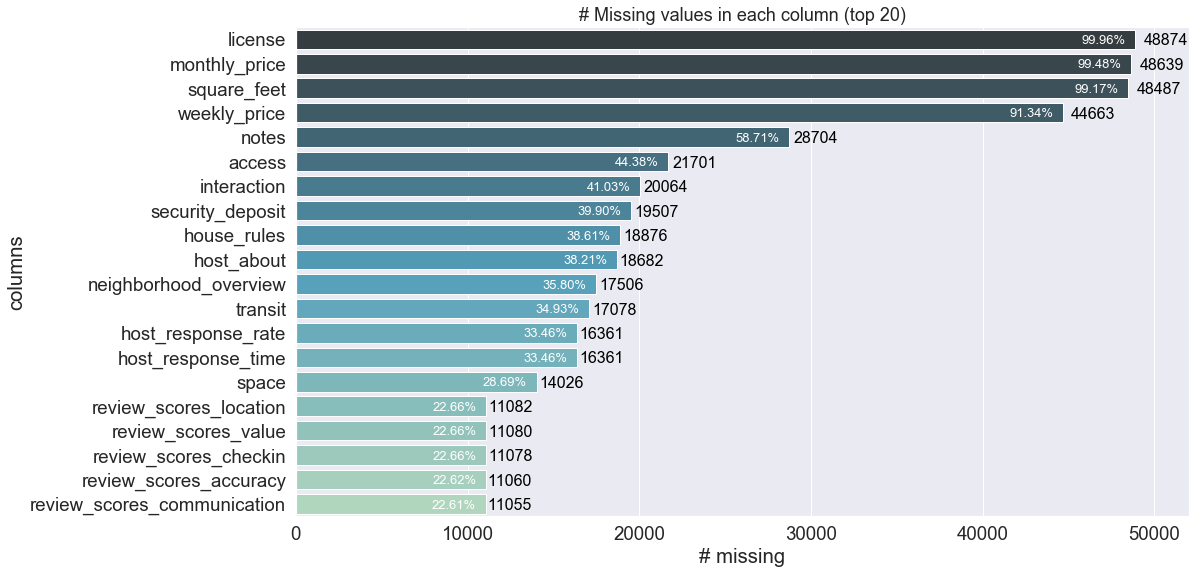

In [18]:
missing = ab_tidy.isnull().sum()/len(ab_tidy)*100

mv = pd.DataFrame([missing[missing>2],pd.Series(ab_tidy.isnull().sum()[ab_tidy.isnull().sum()>=1000])], 
                   index=['% missing','# missing']).transpose()

# print(mv.sort_values(by = ['# missing'], ascending = False))

mv_plot = mv.sort_values(by = ['# missing'], ascending = False).reset_index() \
               .rename(columns = {'index':'columns'}).head(20)

def mv_plot(data, title, threshold = 1000, xlim = 50000, top = 20, label_size = 15):
    '''
    function to plot # and % of missing values in each column of a dataframe
    
    Input
    
    
    '''
    # adjust font size
    sns.set(font_scale = 1.7)

    missing = data.isnull().sum()/len(ab_tidy)*100

    mv = pd.DataFrame([missing[missing>2],pd.Series(data.isnull().sum()[data.isnull().sum()>=threshold])], 
                       index=['% missing','# missing']).transpose()

    # print(mv.sort_values(by = ['# missing'], ascending = False))

    mv_plot = mv.sort_values(by = ['# missing'], ascending = False).reset_index() \
                   .rename(columns = {'index':'columns'}).head(top)

    fig, ax = plt.subplots(figsize = (16, 9))
    ax = sns.barplot(y = 'columns', x = '# missing', data = mv_plot, palette = 'GnBu_d')
    # add data labels
    x = mv_plot['columns']
    y1 = mv_plot['# missing']
    y2 = mv_plot['% missing']
    for a,b, c in zip(range(0, len(x)), y1, y2):  
        ax.text(b *1.01, a, '%.0f' % b, ha='left', va= 'center_baseline', fontsize=label_size+1, color = 'black', fontname = 'Arial')
        # print(c)
        if np.isnan(c):
            continue
        if abs(c - 0) >= 0.01:
            ax.text(b - xlim*0.06 , a, '%.2f' % c + '%', ha='left', va= 'center_baseline', fontsize=label_size-2, color = 'white', fontname = 'Arial') 

    # xlim, to include data label
    plt.xlim(0, xlim)
    # set title
    plt.title(title, fontsize = 18)
    

    # add grid line to make it truly ggplot style
    plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            bottom=False,         # ticks along the top edge are off
            labelbottom=True) # labels along the bottom edge are off
    
ab_ms_title = '# Missing values in each column (top 20)'
mv_plot(ab_tidy, ab_ms_title, xlim = 52000)

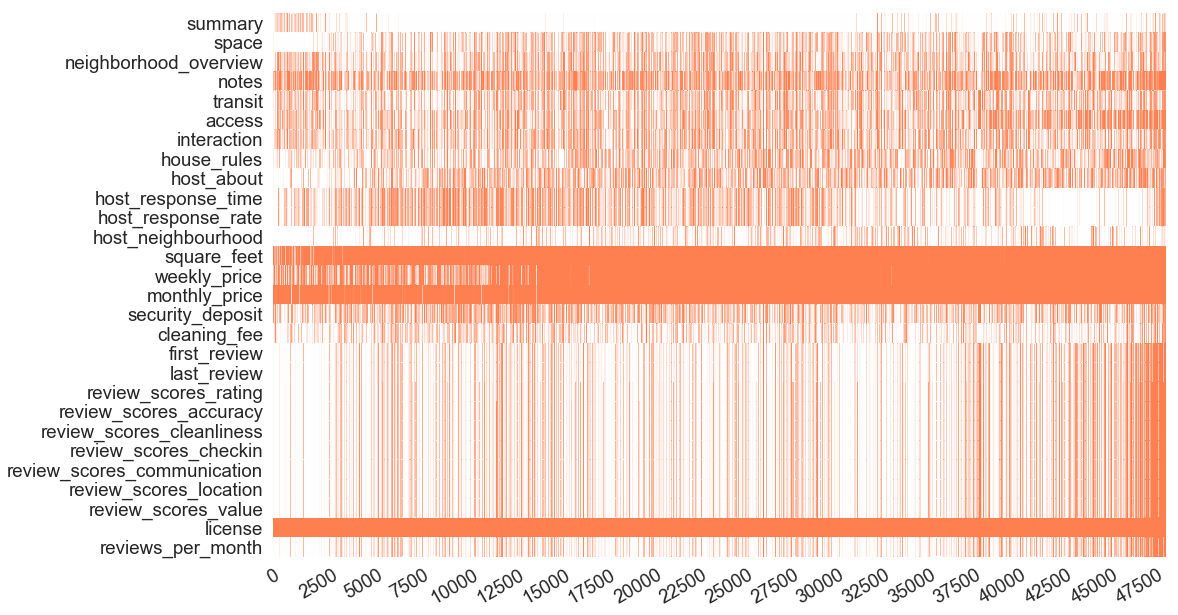

In [19]:
# purely for data exploration, not for busienss presentation
def mv_heatmap(data, tick_itvl, threshold = 1000):
    '''
    Heaptmap to locate missing values in a DataFrame
    
    Input:
    data: a pandas dataframe to inspect
    tick_itvl: the interval of ticks
    threshold: only show columns that has more than the `threshold` number of missing values, default to 1000
    
    Return:
    fig, ax, two matplotlib classes
    '''
    # adjust font size
    sns.set(font_scale = 1.7)

    missing = data.isnull().sum()/len(ab_tidy)*100

    mv = pd.DataFrame([missing[missing>2],pd.Series(data.isnull().sum()[data.isnull().sum()>=threshold])], 
                       index=['% missing','# missing']).transpose()
    
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(data[mv.index].isnull().transpose(), cbar = False, cmap = ["white", "#FF7F50"], alpha = 0.5)
    plt.xticks(rotation=30) # rotate x ticks by 30 degrees
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_itvl))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
    return fig, ax
    
fig, ax = mv_heatmap(ab_tidy, tick_itvl = 2500)

In [20]:
drop_col2 = 'license square_feet notes'.split()

ab_tidy.drop(columns = drop_col2, inplace = True, axis = 1)

In [21]:
ab_tidy['weekly_price'].mask(ab_tidy['weekly_price'].isnull(), ab_tidy['price'] * 7, inplace = True)
ab_tidy['monthly_price'].mask(ab_tidy['monthly_price'].isnull(), ab_tidy['price'] * 30, inplace = True)

print(ab_tidy[['price', 'weekly_price', 'monthly_price']].isnull().sum())

price            298
weekly_price     292
monthly_price    298
dtype: int64


### 2.1.3 Row Filtering

Filtering out broken, unnecessary, or strange observations also help tidy the data.

#### Location Filter

We care about properties in only New York City, so I tested the location across multiple relevant fields and removed properties that are in other locations.

the inconsistency between smart location and 

Which one is relevant:

- neighbourhood: 194 unique values, of more granularity than five boroughs, but not verified

- neighbourhood_cleansed: 221 unique values, of same granularity as `neighbourhood`, verified
 
- neighbourhood_group_cleansed: 5 unique values, presumably one level higher than `neighbourhood_cleansed` and corresponds to the five boroughs perfectly
 
- city: contains duplicated implications mainly due to the using of both upper case and lower case. Besides, some host just confused city with borough, making the field less accurate and not an ideal judger.

- state: one row is empty in this field, should be in NY according to other fields

- market: Inaccurate, should all be restored to "New York"
 
- smart_location
 
- country: All United States

- country_code: All US
 
- is_location_exact: Boolean

In [22]:
# plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale = 1.7)

In [23]:
ab_tidy = ab_tidy.rename(columns = {'neighbourhood_group_cleansed': 'borough'})

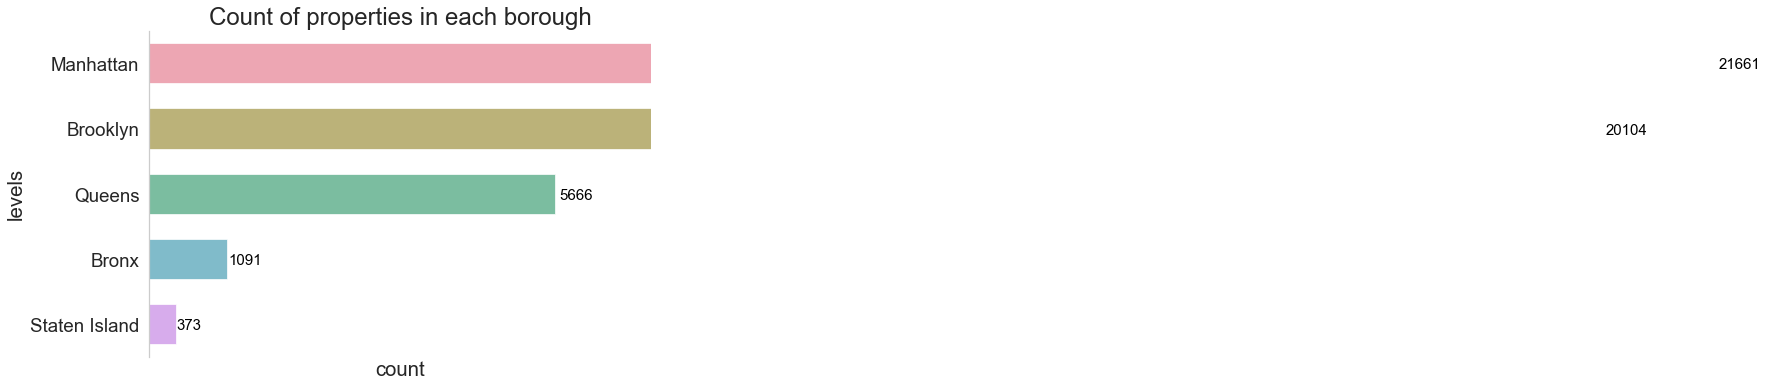

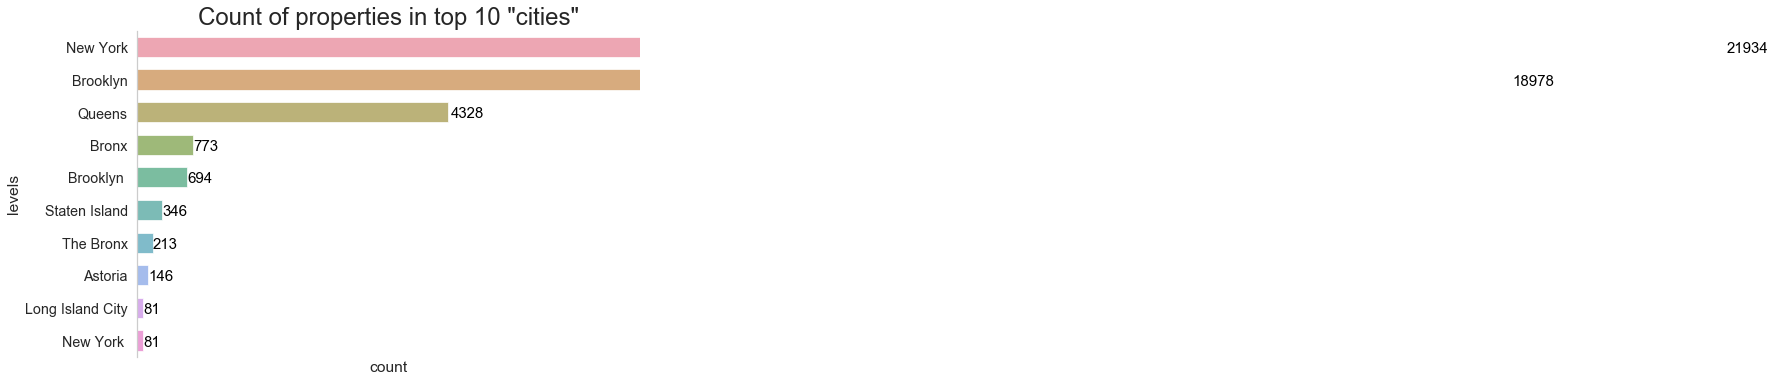

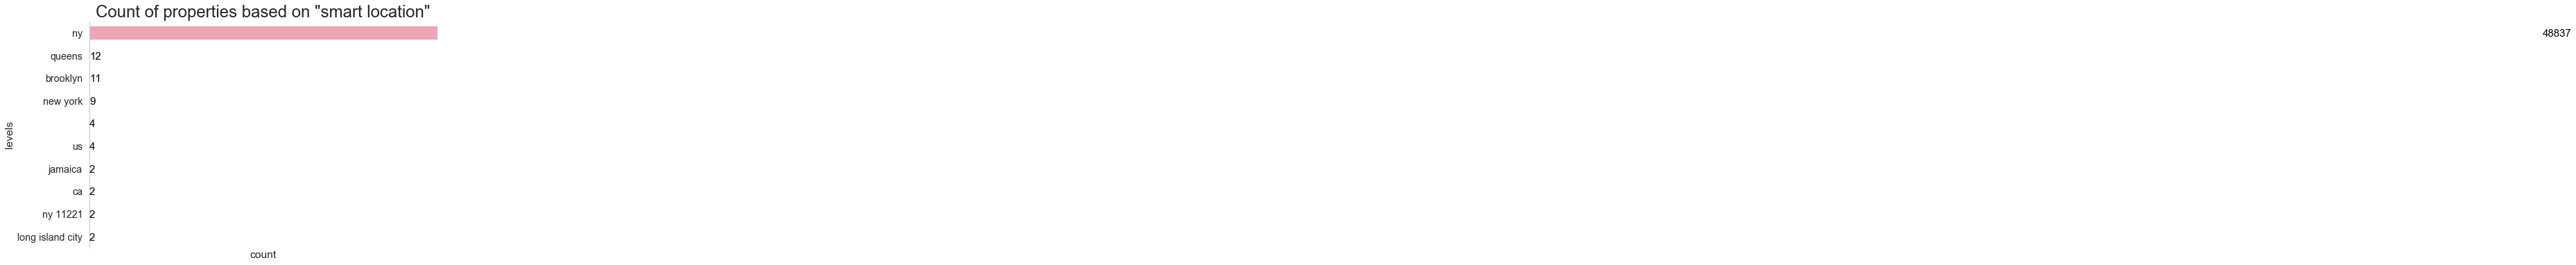

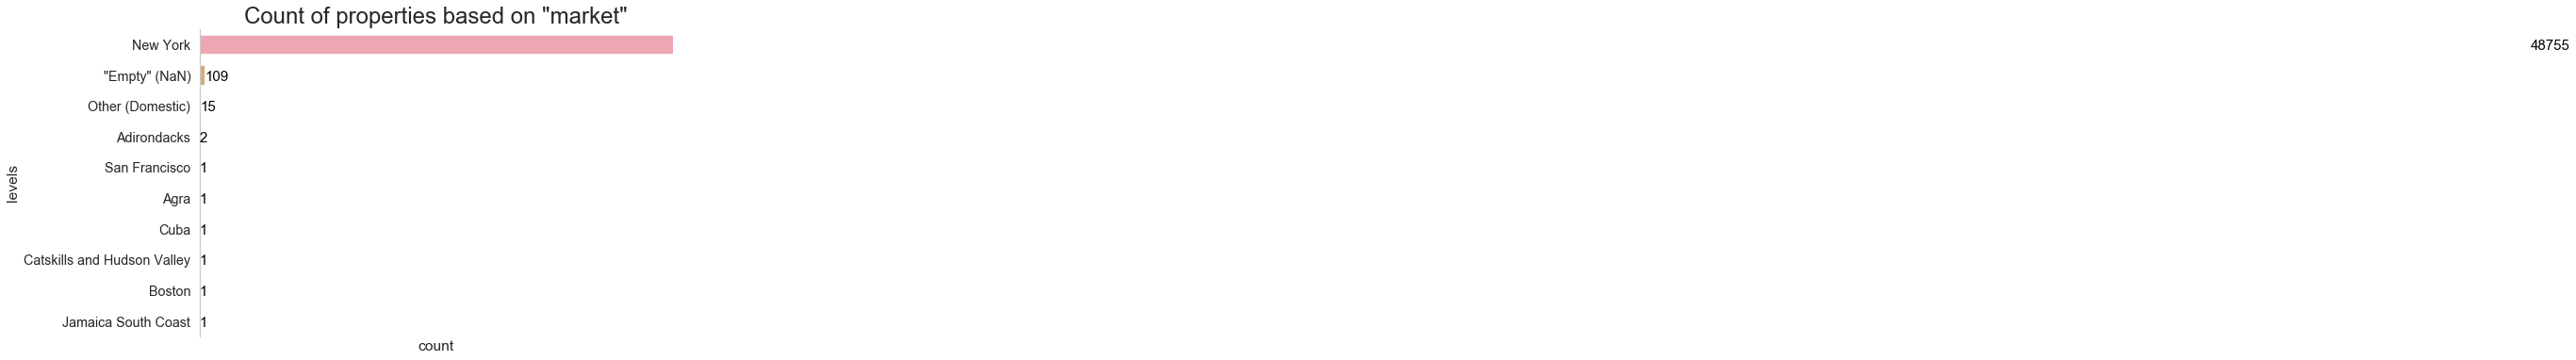

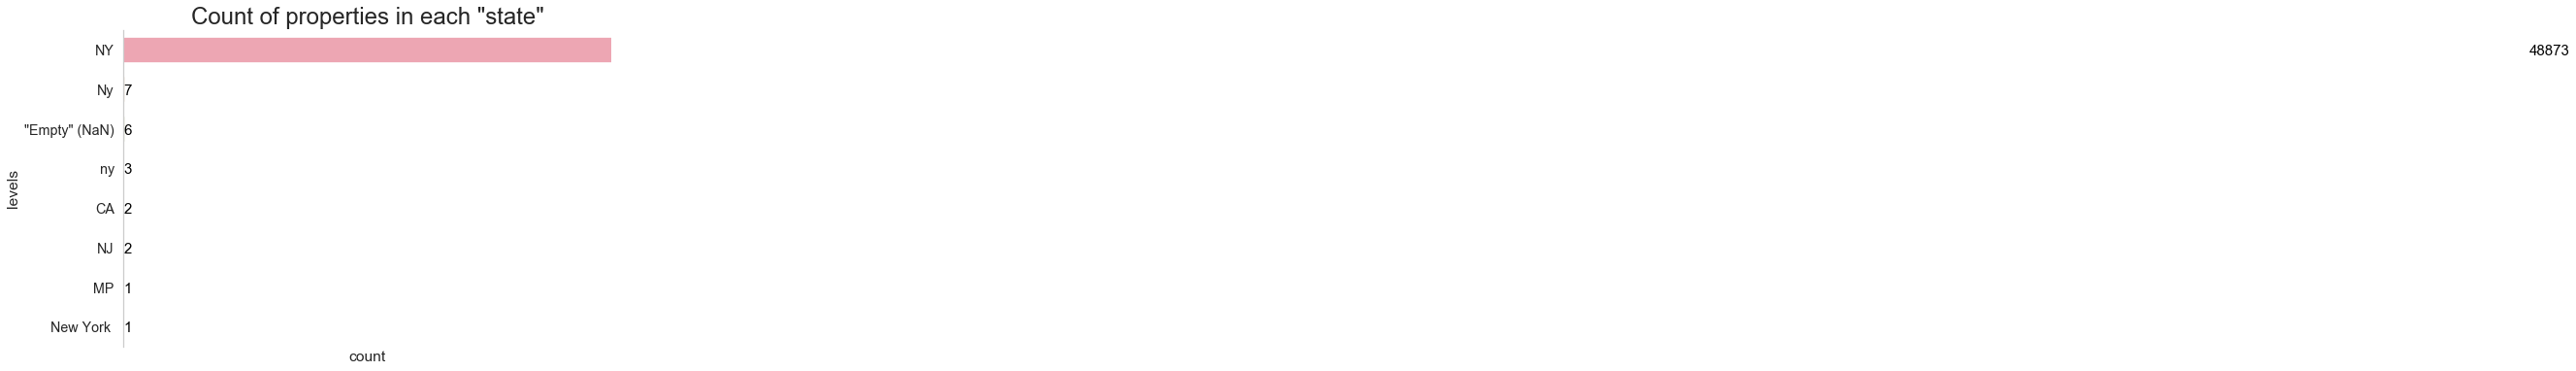

In [24]:
def width_vertical(ax, new_value) :
    '''
    Helper function to change the bar width in a horizontal bar plot
    https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
    '''
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def width_horizontal(ax, new_value) :
    '''
    Helper function to change the bar height in a horizontal bar plot
    Based on
    https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
    '''
    for patch in ax.patches:
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)
        
###### PLOTING ##############

def countplot_h(column_x, data, x_upper_lim, top = 10, size = (9, 6), palette = 'husl', 
                title = 'Horizontal Countplot', ylabel = 'levels', bw = 0.618):
    '''
    A horizontal version of seaborn.countplot() with custom style
    Custom horizontal countplot of each level of `column_x` in `data`, including NaN
    
    Input: 
    column_x: string, the column to plot
    data: a pandas dataframe, a tidied data frame
    size: tuple, size of the plot, default to (9, 6)
    palette: string, the palette of the plot, default to 'husl'
    x_upper_lim: int, the right limit of the plot, adjust it to include the data label
    title: string, title of the plot, defualt to 'Horizontal Countplot'
    ylabel: string, the label of y axis, default to 'levels'
    bw: float <= 1, bar width
    top: int, how many levels to show at most, default to 10
    
    Output: a horizontal countplot of a categorical column
    '''
    sns.set_style('whitegrid')
    df_cnt = data[column_x].value_counts(dropna = False) \
               .reset_index().rename(columns = {'index':'columns', column_x:'count'}).head(top)
    df_cnt['columns'][df_cnt['columns'].isnull()] = '"Empty" (NaN)'
    
    if (df_cnt['columns'].dtype == "float64") | (df_cnt['columns'].dtype == "int64"):
        df_cnt.sort_values(by = 'columns', inplace = True)
    
    fig, ax = plt.subplots(figsize = size)
    ax = sns.barplot('count', 'columns', data = df_cnt, palette = palette, alpha = 0.7, orient = 'h')

    # change width of horizontal bar: height
    width_horizontal(ax, bw)
    
    # add data labels
    x = df_cnt['columns']
    # print(x)
    y = df_cnt['count']
    # print(y)
    for a,b in enumerate(y):  
        ax.text(b *1.01, a, '%.0f' % b, ha='left', va= 'center_baseline', fontsize=15, color = 'black', fontname = 'Arial') 
    
    # xlim, to include data label
    plt.xlim(0, x_upper_lim)
    # set title
    plt.title(title, fontsize = 24)
    # set y label
    plt.ylabel('levels')
    # add grid line to make it truly ggplot style
    ax.grid(b = False)
    # remove ticks of both axes
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    sns.set(font_scale = 1.3)
    sns.despine(right=True, bottom=True, top=True)
    plt.xticks([])
    
# remember to comment out the statement at last    
title = 'Count of properties in each borough'
countplot_h(column_x = 'borough', data = ab_tidy, x_upper_lim = 7000, title = title)
# city
# print(airbnb['city'].value_counts(dropna = False))
countplot_h(column_x = 'city', data = ab_tidy, x_upper_lim = 7000, title = 'Count of properties in top 10 "cities"')

# Check `smart_location`

## Excepts for CA, all are NY related. For example, Jamaica is a district in New York City

def smt_loc(x):
    """
    Extracting state information from `smart_location` and tidy it
    
    Input:
    x: atomic value in column `smart_location`
    
    Output:
    Tidied state information
    """
    if len(x) == 1:
        return x[0].strip().lower()
    else:
        return x[1].strip().lower()

smt_loc = pd.DataFrame([smt_loc(x) for x in ab_tidy['smart_location'].str.split(', ')])
smt_loc.columns = ['smart location']

countplot_h(column_x = 'smart location', data = smt_loc, x_upper_lim = 7000, title = 'Count of properties based on "smart location"')

countplot_h(column_x = 'market', data = ab_tidy, x_upper_lim = 10000, title = 'Count of properties based on "market"')

countplot_h(column_x = 'state', data = ab_tidy, x_upper_lim = 10000, title = 'Count of properties in each "state"')

Obviously, some location fields are mis-recorded, we can fill them with the correct information. For smart location, I have determined that it is inputed by hand thus inaccurate. We will not take the column into consideration in the analysis.

In [25]:
ab_tidy[['neighbourhood', 'borough', 'market', 'smart_location', 'state']]\
         [(ab_tidy['market'] != "New York") &
          (ab_tidy['state'] != "New York")]

,neighbourhood,borough,market,smart_location,state
820,Queens,Queens,Other (Domestic),"Queens, NY",NY
3542,Brooklyn,Brooklyn,Boston,"Brooklyn, NY",NY
5003,Manhattan,Manhattan,Los Angeles,"New York, NY",NY
5475,Bedford-Stuyvesant,Brooklyn,Atlanta,"Brooklyn, NY",NY
6010,Brooklyn,Brooklyn,Paris,"Brooklyn, NY",NY
...,...,...,...,...,...
18308,Brooklyn,Brooklyn,NaN,"Brooklyn, NY",NY
18413,Corona,Queens,NaN,"Queens, NY",NY
18437,Queens,Queens,NaN,"Queens, NY",NY
21237,Upper East Side,Manhattan,Other (Domestic),"New York, NY",NY


In [26]:
# correcting location
ab_tidy['state'] = 'New York'
ab_tidy['market'] = 'New York'
ab_tidy['city'] = 'New York City'

#### Two bedrooms properties only

Since the real estate company has already concluded that two bedroom properties are the most profitable, I filtered the data to this kind only. 


In [27]:
ab_tidy = ab_tidy[ab_tidy['bedrooms'] == 2]

#### Drop properties that does not come with a zipcode

Originally I attempted filling the `zipcode` column with external dataset based on the latitude and longitude in the AirBnB dataset, while none of these resources returns the zipcode accurately, so I decided to drop these rows.

While we can also notice from previous tidying that there are some empty cells under `price`. I imputed them based on a regression model I built in chapter 4.

In [28]:
ab_tidy = ab_tidy.dropna(subset=['zipcode', 'price'])
ab_tidy = ab_tidy.reset_index(drop=True)

#### Drop properties that have too high a minimum nights

Some properties have a very high minimum nights requirement, which is higher than a year. As the project focuses on short-term rental, those properties are not of our interests as well. We would like to select 180 as the boundary between short-term and long-term rental after research.

"*Unfortunately, legal restrictions on short-term rentals are not uniform and can be confusing.*" So the determination of short-term is at our discretion.

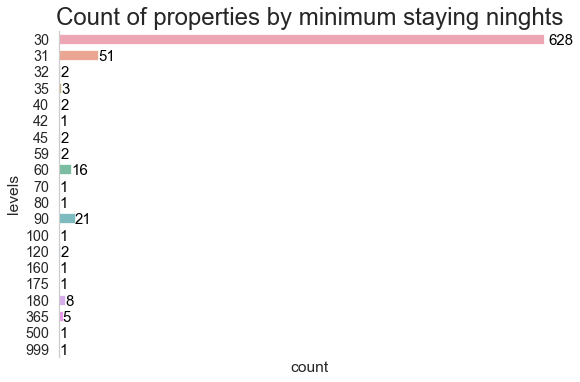

In [29]:
countplot_h(column_x = 'minimum_nights', data = ab_tidy[ab_tidy['minimum_nights'] >=30], x_upper_lim = 650, title = 'Count of properties by minimum staying ninghts', top = 20)

In [30]:
ab_tidy = ab_tidy[ab_tidy['minimum_nights'] <= 180]

#### Checking duplicated rows

Turns out that there is no duplicated observations in the AirBnB dataset.

In [31]:
# No duplicated values
print('Number of duplicated observations:', sum(ab_tidy.duplicated()))

Number of duplicated observations: 0


#### Final check of missing values

Before diving into the actual analysis, inspecting the missing values again renders us a holistic view of the data at hand.

1. There are still a lot of missing values, but they will not compromise our analysis and we can further clean them when necessary
2. Many properties do not have review, they may be very new on AirBnB, a

(<Figure size 1152x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f4020baa48>)

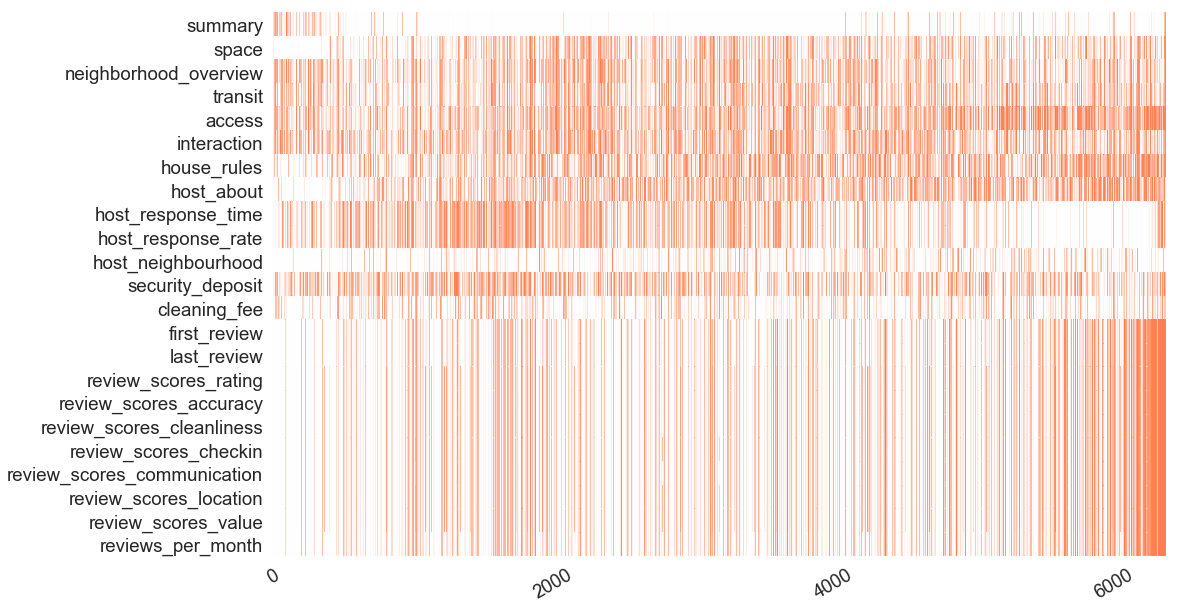

In [32]:

mv_index = list(mv.index)

col_tidy = [x for x in mv_index if x not in ['square_feet', 'notes', 'license']]

mv_heatmap(ab_tidy, tick_itvl = 2000)

## 2.2 Tidying Zillow dataset

First, I prepared the `zillow` dataset by renaming `RegionName` to `zipcode` to make it consistent with that in the AirBnB dataset.

In [33]:
zl_tidy = zillow.rename(columns = {'RegionName':'zipcode'})

### 2.2.1 Data Wrangling

For the information set, which includes all the descriptions other than the median property values, 

For the time series set, I filtered out zipcodes that is not in our AirBnB dataset since the analysis procedure is standard and universal. After going through the analysis of properties in the New York City, we can easily acquire the idea that how it can be applied to other locations in the future. For the convenience of applying time series analysis, I also transposed it to have the data listed in a vertical direction.

In [34]:
# separate other fields from time series
info_col = ['RegionID', 'zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

zl_info_tidy = zl_tidy[info_col]

# all information were
zl_info_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 7 columns):
RegionID      8946 non-null int64
zipcode       8946 non-null object
City          8946 non-null object
State         8946 non-null object
Metro         8696 non-null object
CountyName    8946 non-null object
SizeRank      8946 non-null int64
dtypes: int64(2), object(5)
memory usage: 489.4+ KB


In [35]:
# extract the time series part from the Zillow dataset for forecasting
ts_col_r = info_col[:]
ts_col_r.remove('zipcode')
med_ts_tidy = zl_tidy.drop(ts_col_r, axis = 1).rename(columns = {'RegionName':'zipcode'})
med_ts_tidy = med_ts_tidy[med_ts_tidy['zipcode'].isin(ab_tidy['zipcode'])]
med_ts_tidy = med_ts_tidy.set_index('zipcode').transpose().dropna(how = 'all')

# med_ts_tidy.to_csv('med_ts_tidy.csv')
print('Number of zipcodes: ', med_ts_tidy.shape[1])
print('Length of time series: ', med_ts_tidy.shape[0])
med_ts_tidy

Number of zipcodes:  25
Length of time series:  255


zipcode,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,10021,10014,10036,11434,10306,10022,11217,10013,11231,10304,10305,11003,10309,10308,10303
1996-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123100.0,NaN,NaN,NaN,NaN,NaN,NaN,138100.0,NaN,NaN,NaN,NaN,117500.0,131900.0,130500.0,129100.0,149600.0,99200.0
1996-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124000.0,NaN,NaN,NaN,NaN,NaN,NaN,136900.0,NaN,NaN,NaN,NaN,113700.0,131900.0,130300.0,129200.0,148200.0,102000.0
1996-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123900.0,NaN,NaN,NaN,NaN,NaN,NaN,135900.0,NaN,NaN,NaN,NaN,111200.0,131400.0,130300.0,129000.0,146800.0,103900.0
1996-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123300.0,NaN,NaN,NaN,NaN,NaN,NaN,134500.0,NaN,NaN,NaN,NaN,111100.0,130800.0,130100.0,129400.0,144800.0,105400.0
1996-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122900.0,NaN,NaN,NaN,NaN,NaN,NaN,132900.0,NaN,NaN,NaN,NaN,110400.0,130200.0,129600.0,130300.0,143100.0,106900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02,1317300.0,1929800.0,1582900.0,2319600.0,1916500.0,1398100.0,466400.0,338600.0,1040800.0,1801100.0,1649800.0,2441900.0,1736600.0,361900.0,331700.0,1774500.0,1225000.0,3183300.0,1182900.0,303800.0,394500.0,345300.0,364900.0,378000.0,304700.0
2017-03,1333700.0,1955000.0,1598900.0,2342100.0,1965700.0,1399900.0,470900.0,344100.0,1035800.0,1847900.0,1688500.0,2460900.0,1750100.0,370800.0,339000.0,1812700.0,1219600.0,3160200.0,1202200.0,308300.0,403800.0,347600.0,371100.0,387800.0,309500.0
2017-04,1352100.0,2022400.0,1646100.0,2365900.0,2045300.0,1400500.0,475700.0,347800.0,1050000.0,1922800.0,1731400.0,2494900.0,1735500.0,377100.0,343500.0,1914600.0,1238100.0,3193500.0,1213200.0,313800.0,412000.0,346000.0,377200.0,396400.0,315400.0
2017-05,1390000.0,2095000.0,1720500.0,2419700.0,2109100.0,1407300.0,477100.0,352300.0,1066200.0,2015700.0,1774100.0,2498400.0,1717100.0,380200.0,347800.0,1997800.0,1276400.0,3262200.0,1211700.0,321300.0,418900.0,345400.0,383700.0,402900.0,322100.0


### 2.2.2 Missing Values and Checking Rows

Checking the missing values in the first derived dataset `zl_info_tidy` from `zillow` told us that it contains 250 missing values in the `Metro` field. However, since we know from the `AirBnB` dataset that all zipcodes are in New York and we have compared them and filtered observations of `zillow` that are not in the `AirBnB`, we can impute them with "New York" safely.

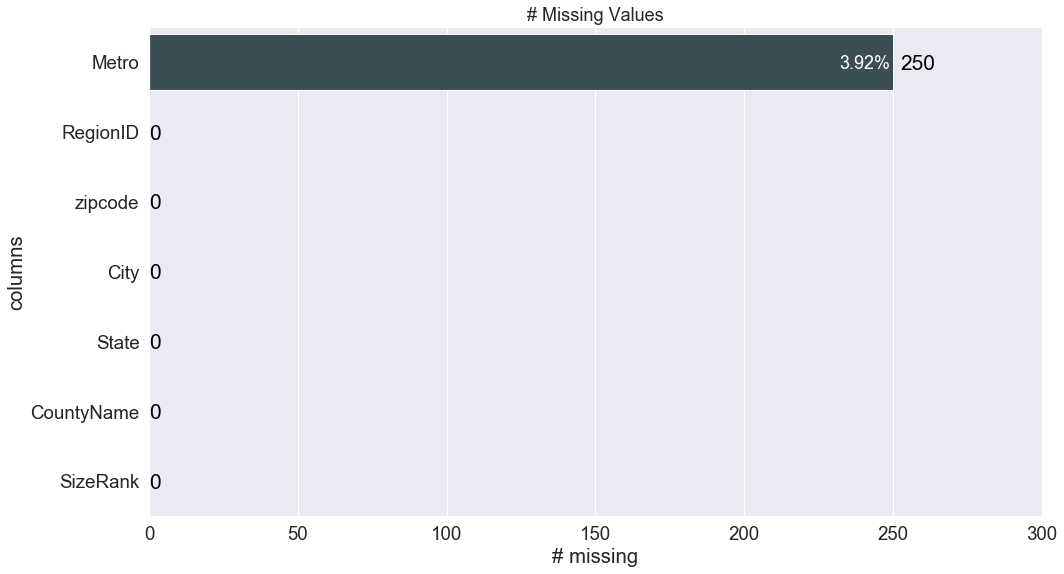

In [36]:
mv_plot(zl_info_tidy, '# Missing Values', xlim = 300, threshold = 0, label_size = 20)

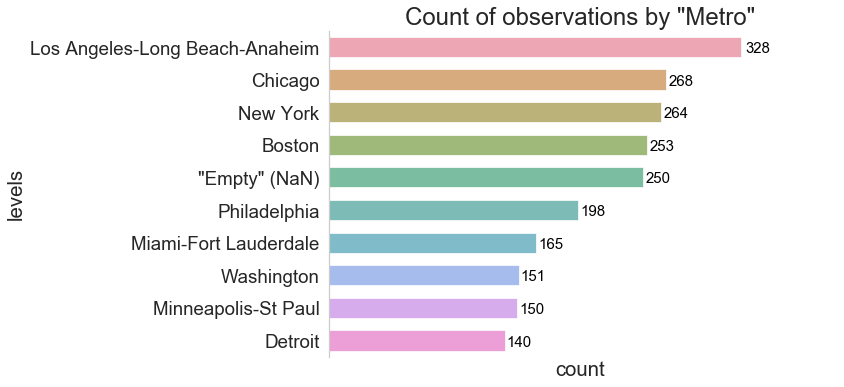

In [37]:
countplot_h(column_x = 'Metro', data = zl_info_tidy, x_upper_lim = 400, title = 'Count of observations by "Metro"')

For `med_ts_tidy`, the time series containing the median property values of 25 zipcodes across a time range, we can see that the values are missing in zipcode 10036 for a couple of years using a heatmap, which showed not only how many were missing but also where the emptinesses are located. 

That means we have to either exclude the the part before the missing values or impute them.

The method is useful for the inspection of missing values in a time series because we will forecast the current property values based on the time series while missing values will have a material impact on the forecating accuracy.

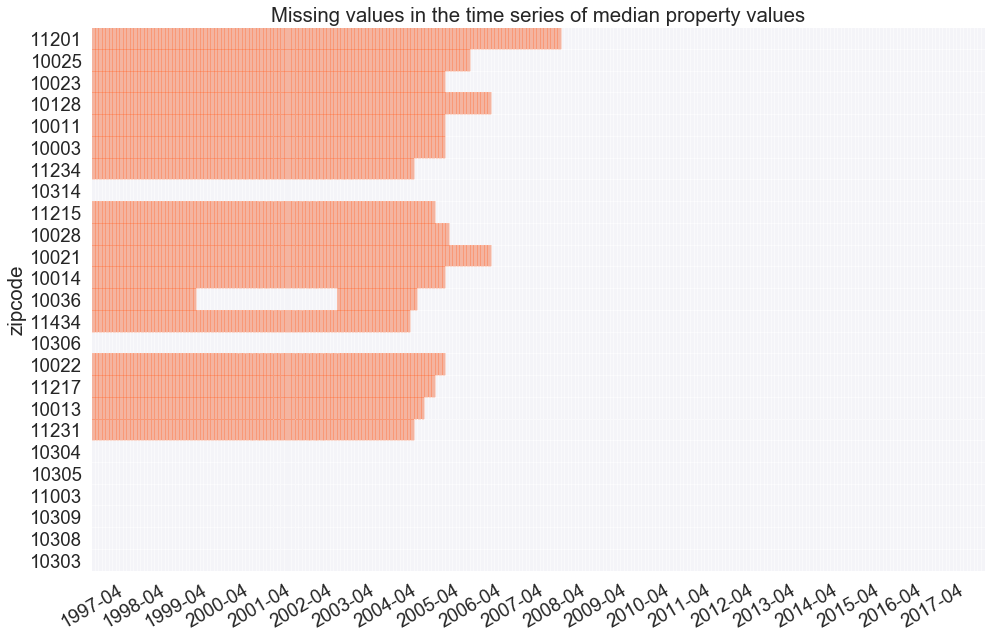

In [38]:
fig, ax = mv_heatmap(med_ts_tidy, tick_itvl = 12, threshold = 0)
_ = ax.set_xticklabels(labels = med_ts_tidy.index[::12])
_ = ax.set_title("Missing values in the time series of median property values")

## 2.3 A Glance at the Data Bank before Analysis

**Final AirBnB & Zillow Data Files – Dataset Level Metadata**

| **Data File(s)** | **Description**                                              |
| :--------------- | :----------------------------------------------------------- |
| ab_tidy          | Information  on the listing including location, number of bedrooms, room types (entire  home/private home/shared home) |
| zl_info_tidy     | Data from zillow containing the descriptive information about properties |
| med_ts_tidy      | Time indexed cost data to determine the average property price for 2  bedroom |
| med_med_ts       | Time indexed median property values of each borough          |

 
**AirBnB Detailed Listings Dataset – Column Level Metadata for Derived Fields**

| **Field**              | **Description**                                              |
| :--------------------- | :----------------------------------------------------------- |
| calendar_updated_date  | The date when the host update the property information, derived field  from `calendar_updated_date` |
| calendar_updated_weeks | The number of weeks from when the host update the property information to  when the data were scraped, derived field from `calendar_updated_date` and  `last_scraped` |
| borough                | Renamed from `neighoubourhood_group_cleansed`                |

**Zillow Median Home Value Dataset – Column Level Metadata for Derived Fields**

No field was derived from the dataset. The only changes are:

1. I separated the dataset into two as shown in the dataset level metadata
2. I transponsed the median property value part so that the zipcode serves as columns and the time as the row index.

## 2.4 Function to Automate Data Munging

To automate the data cleaning and binding process, we have to make several assumptions that restrict the context of usage.

1. (看给kessler发的邮件)
2. The new data come in by batches, neither one by one nor as a whole new set;


In [39]:
def tidy_airbnb(data):
    '''
    wrap up my tidying process for *AirBnB* dataset

    Input: a pandas dataframe input from the designated resource
    AirBnB data:  Download http://data.insideairbnb.com/united-states/ny/new-york-city/2019-07-08/data/listings.csv.gz


    Output: a tidied data frame
    '''
    
    import numpy as np
    import pandas as pd
    import re
    from datetime import timedelta
    import dateutil.relativedelta
    import datetime
    
    data.astype({'zipcode': str, 'weekly_price': str, 'monthly_price': str, 
                              'license': str, 'jurisdiction_names': str})
    ab_tidy = data

    #### 1. Tidy the data type ####

    ## Numeric values
    dollar_col = 'price weekly_price monthly_price security_deposit cleaning_fee extra_people'.split()

    for col in dollar_col:
        ab_tidy[col] = pd.to_numeric(airbnb[col].str.replace('$', ''), errors = 'coerce')

    # specially for host_response rate, change to decimals
    ab_tidy['host_response_rate'] = pd.to_numeric(airbnb['host_response_rate'].str.replace('%', ''), errors = 'coerce') / 100

    ## Boolean in string
    def s2b(x):
        if (not pd.isnull(x)) and type(x) == str:
            return 't' in x
        return x

    boolean_col = 'host_is_superhost host_has_profile_pic host_identity_verified is_location_exact has_availability requires_license instant_bookable is_business_travel_ready require_guest_profile_picture require_guest_phone_verification'.split()
        
    for col in boolean_col:
        ab_tidy[col] = [s2b(x) for x in airbnb[col]]
        ab_tidy[col] = ab_tidy[col].astype('bool')
    
    ## Datetime Object
    # Use pd.to_datetime to easily convert it
    date_col = 'last_scraped host_since calendar_last_scraped first_review last_review'.split()

    for col in date_col:
        ab_tidy[col] = pd.to_datetime(ab_tidy[col])
        
    # For calendar_updated only
    # 3 weeks ago, 24 months ago....
    def update2date(i):
        '''Function to find the update date based on time difference from calendar_updated'''
        delta = ab_tidy.loc[i, 'calendar_updated']
        end = ab_tidy.loc[i, 'last_scraped']
        
        if (not pd.isnull(delta)) and (not pd.isnull(end)):
            c = delta.split(' ')
            if c[0] == 'a':
                c[0] = 1
            
            if len(c) == 1:
                if c[0] == 'today':
                    return end
                elif c[0] == 'yesterday':
                    return end - timedelta(days = 1) 
            else:
                if 'week' in c[1]:
                    return end - timedelta(weeks = int(c[0]))
                elif 'month' in c[1]:
                    return end - dateutil.relativedelta.relativedelta(months = int(c[0]))
                elif 'day' in c[1]:
                    return end - timedelta(days = int(c[0]))    
        else:
            # numpy must be imported
            return np.nan
        
    def num_weeks(start, end): 
        '''
        To  find the time difference in week, 
        return an integer that is equal to the bottom of the exact number of weeks
        '''
        if pd.isnull(start) | pd.isnull(end):
            return np.nan
        return int((end-start).days/7)
    # create two derived fields

    # calendar_updated_date, by subtracting the week from last_scraped
    ab_tidy['calendar_updated_date'] = [update2date(i) for i in range(len(ab_tidy))]

    # calendar_updated_weeks
    ab_tidy['calendar_updated_weeks'] = [num_weeks(ab_tidy.loc[i, 'calendar_updated_date'], 
                                                ab_tidy.loc[i, 'last_scraped']) for i in range(len(ab_tidy))] 
    
    
    ## Encode Categorical or Ordinal Fields
    from pandas.api.types import CategoricalDtype

    # categorical fields
    cat_col = 'room_type bed_type'.split()
    for col in cat_col:
        ab_tidy[col] = ab_tidy[col].astype('category')

    # ordinal fields
    ord_col = 'host_response_time cancellation_policy'.split()
    for col in ord_col:
        ab_tidy[col] = ab_tidy[col].astype(CategoricalDtype(ordered=True))

    cancellation = 'flexible moderate strict strict_14_with_grace_period super_strict_30 super_strict_60'.split()
    ab_tidy['cancellation_policy'] = ab_tidy['cancellation_policy'].cat.reorder_categories(cancellation[::-1], ordered = True)


    #### 2. Column Filtering ####
    drop_col = '''host_acceptance_rate scrape_id jurisdiction_names experiences_offered listing_url 
                thumbnail_url medium_url picture_url xl_picture_url host_url 
                host_thumbnail_url host_picture_url is_business_travel_ready'''.split()

    ab_tidy.drop(columns = drop_col, inplace = True, axis = 1)

    drop_col2 = 'license square_feet notes'.split()

    ab_tidy.drop(columns = drop_col2, inplace = True, axis = 1)

    # fill in prices
    ab_tidy['weekly_price'].mask(ab_tidy['weekly_price'].isnull(), ab_tidy['price'] * 7, inplace = True)
    ab_tidy['monthly_price'].mask(ab_tidy['monthly_price'].isnull(), ab_tidy['price'] * 30, inplace = True)

    #### 3. Row filtering ####
    ab_tidy = ab_tidy[ab_tidy['bedrooms'] == 2]
    
    # rename `neighoubourhood_group_cleansed` to `borough`
    ab_tidy = ab_tidy.rename(columns = {'neighbourhood_group_cleansed': 'borough'})

    ## Location Filter

    # correcting location
    ab_tidy['state'] = 'New York'
    ab_tidy['market'] = 'New York'
    ab_tidy['city'] = 'New York City'

    ## Drop properties that does not come with a zip code
    ab_tidy = ab_tidy.dropna(subset=['zipcode'])
    ab_tidy = ab_tidy.reset_index(drop=True)

    ## Drop properties that have too high a minimum nights
    ab_tidy = ab_tidy[ab_tidy['minimum_nights'] <= 180]

    return ab_tidy

In [40]:
def tidy_zillow(data):
    '''
    wrap up my tidying process for *Zillow* dataset

    Input: a pandas dataframe
    Zillow data:  Zip_Zhvi_2bedroom.csv.zip  

    Output: two dataframes

    
    '''
    zl_tidy = data.rename(columns = {'RegionName':'zipcode'})
    
    #### 1. Data Wrangling ####
    # separate other fields from time series
    info_col = ['RegionID', 'zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
    zl_info_tidy = zl_tidy[info_col]

    # extract the time series part from the Zillow dataset for forecasting
    ts_col_r = info_col[:]
    ts_col_r.remove('zipcode')
    med_ts_tidy = zl_tidy.drop(ts_col_r, axis = 1).rename(columns = {'RegionName':'zipcode'})
    med_ts_tidy = med_ts_tidy[med_ts_tidy['zipcode'].isin(ab_tidy['zipcode'])]
    med_ts_tidy = med_ts_tidy.set_index('zipcode').transpose().dropna(how = 'all')
    
    return zl_info_tidy, med_ts_tidy

#### Functions to merge new data:

Once we automate the cleaning process with the above functions, appending new observations to the old ones become easier.

In [41]:
def merge_airbnb(old, new):
        '''
        Append new data to the old tidied data for airbnb
        
        Input:
        old: the old tidied dataframe
        new: the new untided dataframe
        
        return the merged dataset, excluding duplicates
        '''
        full = pd.DataFrame()
        new = tidy_airbnb(new)
        full = old.append(new, ignore_index = True).drop_duplicates().reset_index(drop = True)
        
        return full

In [42]:
def merge_zillow(info_old, ts_old, new):
        '''
        Append new data to the old tidied data for zillow
        
        Input:
        info_old: the old tidied dataframe of property information part
        ts_old: the old tidied dataframe of time series part
        new: the new untided dataframe of from zillow
        
        return the merged info and ts dataset
        '''
        # initialization
        info_full = pd.DataFrame()
        ts_full = pd.DataFrame()
        # tidying
        info_new, ts_new = tidy_zillow(new)
        # append
        info_full = info_old.append(info_new, ignore_index = True).drop_duplicates().reset_index(drop = True)
        ts_full = ts_old.append(ts_new, ignore_index = True).drop_duplicates().reset_index(drop = True)
        
        
        return info_full, ts_full

# 3. Determing the Cost - Time Series Analysis

The profit comprises of two parts: revenue and cost, while the only thing at hand now is the historical median property values till July, 2017. We need to know the purchasing price at, at least, now, Feburary, 2020. This is where **Forecasting** steps in. Forecasting is the process of making predictions of the future based on past and present data by teasing out trend, seasonality, cycles, and random variations.

This chapter is based on a critical assumption the Company agreed with that all properties and all square feet within each locale can be assumed to be homogeneous. So, I aggregate the time serieses into the five borough by taking the median value of each interval -- month in this case.

## 3.1 Exploring the Time Series

Exploring the time series after some data wrangling with an interactive graph enable us to take a closer look at the evolving way of the median property price.

#### Impute Missing Values in A Time Series

We need to make sure the data is ready for the analysis.

As shown in the heatmap above "Missing values in the time series of median property values", the zipcode 10036 comes with a few missing values. The application of forecasting model requires the time series be continuous, so the rows with missing data should be either dropped or filled with appropriate values.

Here I emlpoyed the `spline` imputation method as suggested by the [Imputing the time-series using python](https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460). The article compared 13 popular imputing methods and determined the `spline` as with the highest R-squared.

The Bronx does not have any value, we fill it with the whole New York's median based on my assumption that the median of the whole city is the best approximation of missing property values on a given time

In [43]:
zip_10036 = med_ts_tidy[['10036']]

# trim the empty cells from the left of the series, according to the heatmap
first_valid_index = list(zip_10036.index).index(zip_10036.first_valid_index())
zip_10036 = zip_10036.iloc[first_valid_index:]

zip_10036.index = pd.to_datetime(zip_10036.index)

zip_10036['InterpolateSLinear'] = zip_10036.interpolate(method='slinear')

# med_ts_tidy['10036'].iloc[75:]

med_ts_tidy['10036'].iloc[first_valid_index:] = list(zip_10036['InterpolateSLinear'])

#### Plot The Time Series

In [44]:
# Whole NYC
med_med_ts = pd.DataFrame(med_ts_tidy.median(axis = 1))
med_med_ts = med_med_ts.reset_index().rename(columns = {'index':'month', 0: 'median value'})
med_med_ts['month'] = pd.to_datetime(med_med_ts['month'])
med_med_ts = med_med_ts.set_index('month')

# each borough's zip code for two bedroom properties
mht_zip = list(ab_tidy[ab_tidy['borough'] == 'Manhattan']['zipcode'])
bkl_zip = list(ab_tidy[ab_tidy['borough'] == 'Brooklyn']['zipcode'])
qun_zip = list(ab_tidy[ab_tidy['borough'] == 'Queens']['zipcode'])
brx_zip = list(ab_tidy[ab_tidy['borough'] == 'Bronx']['zipcode'])
stl_zip = list(ab_tidy[ab_tidy['borough'] == 'Staten Island']['zipcode'])

zl_mht_zip = [x for x in med_ts_tidy.columns if x in mht_zip]
zl_bkl_zip = [x for x in med_ts_tidy.columns if x in bkl_zip]
zl_qun_zip = [x for x in med_ts_tidy.columns if x in qun_zip]
zl_brx_zip = [x for x in med_ts_tidy.columns if x in brx_zip] 
zl_stl_zip = [x for x in med_ts_tidy.columns if x in stl_zip]

med_med_ts['Manhattan'] = list(med_ts_tidy[zl_mht_zip].median(axis = 1))
med_med_ts['Brooklyn'] = list(med_ts_tidy[zl_bkl_zip].median(axis = 1))
med_med_ts['Queens'] = list(med_ts_tidy[zl_qun_zip].median(axis = 1))
med_med_ts['Bronx'] = list(med_ts_tidy[zl_brx_zip].median(axis = 1))
med_med_ts['Staten Island'] = list(med_ts_tidy[zl_stl_zip].median(axis = 1))

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['median value'], name = 'Entire NYC', line_color = '#FF4500'))
fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['Manhattan'], name = 'Manhattan', line_color = '#FF69B4'))
fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['Brooklyn'], name = 'Brooklyn'))
fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['Queens'], name = 'Queens'))
fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['Bronx'], name = 'Bronx'))
fig.add_trace(go.Scatter(x=med_med_ts.index, y=med_med_ts['Staten Island'], name = 'Staten Island'))

fig.update_layout(title_text='Median Property Value Time Series (Interactive Plot)', 
                  xaxis_rangeslider_visible=True)
fig.show()

In [46]:
med_med_ts['Bronx'] = med_med_ts['median value']

## 3.2 Forecasting with Linear Exponential Smoothing

It is clear from the graph above that the series comes without much seasonality but with a trend, so it is suggestible for us to forecast the value using Linear Exponential Smoothing, also known as Holt's method.

For thoes who interested in the technical details, please refer the appendix. Exponential Smoothing forecast future values by assigning weights to past data in an exponentially decaying way so that the most recent data yields the highest weight.

For modeling processes below, the lag is 32 becasue we want to predict the current (Feb, 2020) replacement cost of the property, essentially 32 months from June, 2017.

With the process below, I compared different Exponential Smoothing model using different compositions of hyperparameters, and it turns out that the Holt's model with `alpha = 1, beta = 1` is the best. According to the out-of-sample accuracy, Holt's scores the highest.

In [47]:
#https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

i = ''
nyc_group = ['brooklyn', 'queens', 'manhattan', 'the bronx', 'staten island', 'staten', 'bronx']
while i not in nyc_group:
    print('Brooklyn, Queens, Manhattan, The Bronx, Staten Island')
    i = str(input("Please indicate the borough you would like to inspect from above: ")).lower()

map_borough = {'brooklyn':'Brooklyn', 'queens':'Queens', 'manhattan':'Manhattan', 
               'the bronx':'The Bronx', 'bronx': 'The Bronx', 'staten island':'Staten Island', 
               'staten':'Staten Island'}

locale = map_borough[i]
column_i = list(med_med_ts).index(locale)

lag = 32 # from 2017-06-01 to 2020-02-01

# the dataset cannot be all NaNs
first_valid_index = list(med_med_ts.index).index(med_med_ts[locale].first_valid_index())
train = med_med_ts.iloc[first_valid_index:-lag, column_i:column_i+1]
test = med_med_ts.iloc[-lag:, column_i:column_i+1]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

pred = test.copy()

# Damped = T
model1 = ExponentialSmoothing(np.asarray(train.iloc[:, 0]), trend = 'mul', seasonal = None, damped = True)
# Simple Exponential Smoothing
model2 = ExponentialSmoothing(np.asarray(train.iloc[:, 0]), trend = 'mul', seasonal = None, damped = False)
# Holt
model3 = Holt(np.asarray(train.iloc[:, 0]))

# model1._index = pd.to_datetime(train.index)
# model2._index = pd.to_datetime(train2.index)

# by default `optimized` is True
fit1 = model1.fit()
fit2 = model2.fit()
fit3 = model3.fit()
pred1 = fit1.forecast(32)
pred2 = fit2.forecast(32)
pred3 = fit3.forecast(32)


for f in [fit1, fit2, fit3]:
    print("alpha="+str(f.params['smoothing_level'])[:4]+", beta="+
          str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False))

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = train.index, y = train.iloc[:, 0], showlegend = False))
fig2.add_trace(go.Scatter(x = test.index, y = test.iloc[:, 0], line_color = "gray", name = "Truth"))
x = 0
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#FF1493','#20B2AA', '#FF8C00')):
    x += 1
    fig2.add_trace(go.Scatter(x = train.index, 
                              y = f.fittedvalues, 
                              line_color = c,
                              showlegend = False))
    if x == 3:
        fig2.add_trace(go.Scatter(x = test.index, 
                                  y = p, 
                                  name = "Holt: "+"alpha="+str(f.params['smoothing_level'])[:4]+", beta="+
                                          str(f.params['smoothing_slope'])[:4]+ ", damping="+
                                          str(True if f.params['damping_slope']>0 else False), 
                              line_color = c))
        continue
    fig2.add_trace(go.Scatter(x = test.index, 
                              y = p, 
                              name = "alpha="+str(f.params['smoothing_level'])[:4]+", beta="+
                                      str(f.params['smoothing_slope'])[:4]+ ", damping="+
                                      str(True if f.params['damping_slope']>0 else False), 
                              line_color = c))

fig2.update_layout(title_text='Median Property Value Time Series - zipcode: ' + str(train.columns[0]), 
                  xaxis_rangeslider_visible=True)
fig2.show()


Brooklyn, Queens, Manhattan, The Bronx, Staten Island
Please indicate the borough you would like to inspect from above: brooklyn
alpha=1.0, beta=0.25, damping=True
alpha=1.0, beta=0.32, damping=False
alpha=1.0, beta=0.32, damping=False


## 3.3 Forecasting with The Model

In the last section we have determined the best model for cost forecasting, it is time to apply it to the actual prediction and wrap it up so that anyone intrigued by the result can employ it in one step and customize how far from now to predict.

In [48]:
# modeling

# lag = 32 becasue
def pred_med_value(data, lag):
    '''
    Forecast the median property value in after "lag" number of periods (month in this case)
    
    Input:
    data: a Pandas DataFrame that has a DateTime as indices and zipcodes as columns
    lag: how many periods between the last observation and period during which the value we want to predict
    
    Return:
    A DataFrame containing all the predicted values of each zipcode
    '''
    
    # from pandas.tseries.offsets import Day, BDay
    from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
    data.index = pd.to_datetime(data.index)
    start_date = data.index[-1]
    pred_index = pd.date_range(start = start_date, periods = lag + 1, freq = 'MS')[1:]
    
    # initialize the prediction result data
    result = pd.DataFrame(index = pred_index)

    for i in range(data.shape[1]):
        # the dataset cannot be all NaNs
        first_valid_index = list(data.index).index(data.iloc[:, i].first_valid_index())
        train = data.iloc[first_valid_index + lag:, i:i+1]

        model = Holt(np.asarray(train.iloc[:, 0]))
        # by default `optimized` is True
        fit = model.fit()
        pred = fit.forecast(lag)
        result[str(train.columns[0])] = pred
    
    return result
        
pred_set = pred_med_value(med_med_ts, 32)

In [49]:
pred_set.tail()

,median value,Manhattan,Brooklyn,Queens,Bronx,Staten Island
2019-10-01,2.009198e+06,3.531020e+06,1492000.0,439353.234204,2.009198e+06,497299.999933
2019-11-01,2.034445e+06,3.582703e+06,1500550.0,442012.278283,2.034445e+06,502299.999931
2019-12-01,2.059691e+06,3.634386e+06,1509100.0,444671.322362,2.059691e+06,507299.999928
2020-01-01,2.084937e+06,3.686069e+06,1517650.0,447330.366441,2.084937e+06,512299.999926
2020-02-01,2.110184e+06,3.737751e+06,1526200.0,449989.410519,2.110184e+06,517299.999923


# 4. Exploration of Profitability - Payback Period

To measure the profitability, I introduce the term `payback period` here. The payback period refers to the amount of time it takes to recover the cost of an investment. Simply saying, it is the length of time an investment reaches a breakeven point. We can look at the metric in this project because the time value of money discount rate is 0% and we do not need to discount the money. I assume that the cost on managing the properties are homogenous as well, so we do not need to offset it in calculating the payback period. But we do need to take the occupancy rate into consideration. We assumed that the rate is 75% and applies to all properties.

The shorter the payback period, the more profitable the property.


## 4.1 Prepare the Analysis Set from The Data Bank

As in the chapter two, we have sorted out three data files that construct a data bank for us to extract data from when we need to conduct any type of analysis. To find out where the most profitable properties are located, I grabbed a `pricing` set from it and explored relevant metrics.


The original `price` is not good enough as the indicator of the actual revenue we the Company can expect because:

  First, the revenue is a composite of label price, cleaning fee, and extra charge for each person, etc.
  Second, though the prices from AirBnB will not be the final price strategy we deploy, we may still consider utilizing the collective intelligence of thousands of hosts on AirBnB that they differentiate their properties by offering discount on weekly or monthly rental or setting up tiered prices for different number of tenants.
  Lastly, as shown in the historgram below, the distribution of `price` has some peaks on hundreds. That is a phenomenon crafted by human beings that we like them. However, it compromises the analysis because it is not ideally distributed.
  
Therefore, I suggest we derive the actual revenue on a daily basis from the fields below:

- `price`
- `weekly_price`
- `monthly_price`
- `cleaning fee`
- `minimum nights`
- `accomodates`
- `extra_people`

According to an official article [AIRBNB ECONOMIC IMPACT](https://blog.atairbnb.com/economic-impact-airbnb/), Airbnb visitors stay on average 6.4 nights, that will be the dividor of our cleaning fee if the minimum nights is smaller than 7 days.

Below is the historgram of `price`.

In [50]:
df = ab_tidy.copy()

df.dropna(subset = "price weekly_price monthly_price cleaning_fee minimum_nights accommodates extra_people".split(), 
          inplace = True)

x_col = """zipcode latitude longitude host_response_rate host_response_time host_is_superhost borough property_type room_type accommodates bathrooms
        beds bed_type review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication 
        review_scores_location review_scores_value instant_bookable cancellation_policy neighbourhood_cleansed""".split()

pricing = df[x_col]

def y_calculator(x, y, z, c, m, n, e):
    """
    x: daily
    y: weekly 
    z: monthly
    c: cleaning fee
    m: minimum nights
    n: accomodates
    e: Additional charge per additional guests
    """
    if np.isnan(m):
        return x+c/6.4+(n-1)*e
    elif m < 7:
        return x+c/6.4+(n-1)*e
    elif m >= 7 & m < 30:
        return y/7+c/m+(n-1)*e
    elif m >=30:
        return z/30+c/m+(n-1)*e
    
pricing['f_price'] = [y_calculator(x, y, z, c, m, n, e) 
                      for x, y, z, c, m, n, e in zip(df['price'], df['weekly_price'], df['monthly_price'],
                                                     df['cleaning_fee'],df['minimum_nights'],df['accommodates'],
                                                     df['extra_people'])]

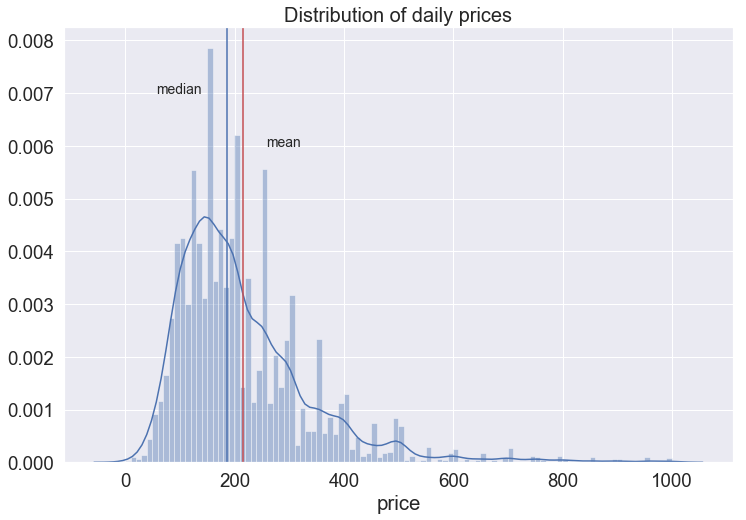

In [51]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(df['price'], kde=True, bins = 100)

price_mean = df['price'].mean()
price_median = df['price'].median()

plt.axvline(price_mean, c='r')
plt.axvline(price_median, c='b')
plt.text(0.3*price_median, 0.007, "median", fontsize = 14)
plt.text(price_mean*1.2,0.006, "mean", fontsize = 14)
plt.title("Distribution of daily prices", fontsize = 20)
plt.show()

The distribution of the transformed `f_price` looks better, the curve is smooth. Besides, prices of large sample by nature obeys a right skewed logarithmically normal distribution because the price cannot be negative. One significant example is the stock price. The general rule is verified in the distribution plot of the log of `f_price`, which is normally distributed.

Text(360.25640706613564, 0.003, 'mean')

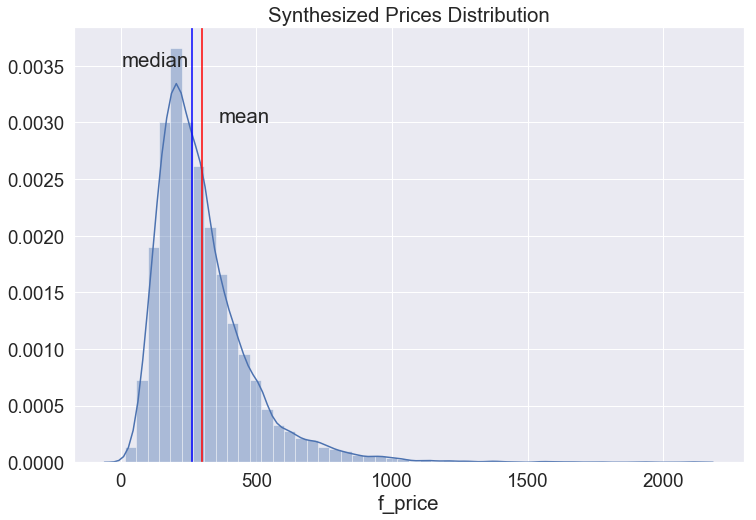

In [52]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = sns.distplot(pricing['f_price'], bins = 50)
plt.title('Synthesized Prices Distribution')
ax.axvline(pricing['f_price'].mean(), c='red')
ax.axvline(pricing['f_price'].median(), c='blue')
ax.text(pricing['f_price'].median()*0.01,0.0035, "median")
ax.text(pricing['f_price'].mean()*1.2,0.003, "mean")


Text(0.5, 1.0, 'Distribution plot of the natural log of `f_price`')

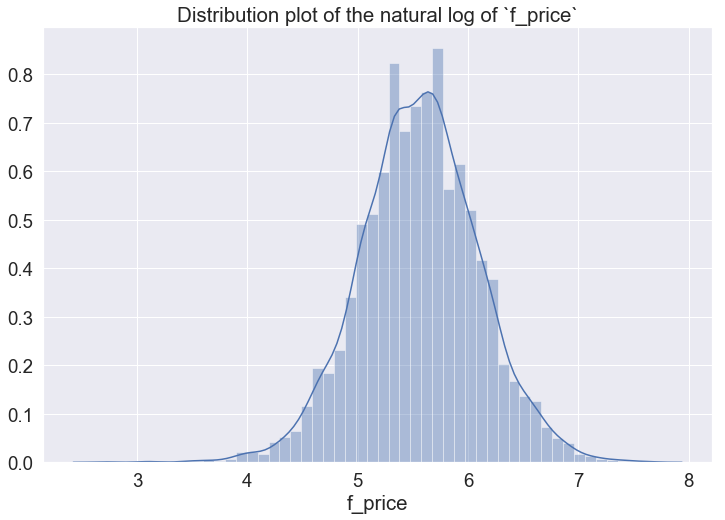

In [53]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(np.log(pricing['f_price']))
plt.title('Distribution plot of the natural log of `f_price`')

**Then let's look at the price distribution by boroughs**. Manhattan's daily reting prices are the highest, Brooklyn's next. While median price  The rank agrees with our common sense about the property value distribution across different boroughs that living in Manahattan is expensive.

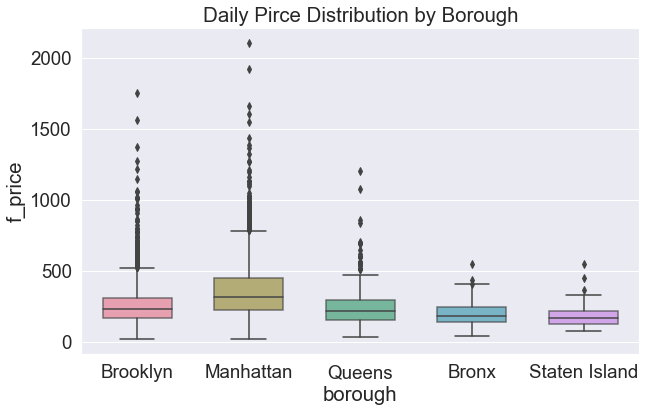

In [54]:
plt.figure(figsize=(10,6))
sns.boxplot(x='borough', y='f_price', data=pricing, palette = 'husl', boxprops=dict(alpha=.7), width = 0.618)
plt.title('Daily Pirce Distribution by Borough')
plt.show()

## Map Analysis

A map gives us a more intuitive glance at where the profitable properties are located, and the airbnb dataset makes it possible by providing latitudes and longitudes. We can combine the map with other layers to consolidate our investing strategy. For example, we can conceptualize a decision very quickly if a new commercial center is going to open on zipcode 10036, so that we know the values of the surrounding properties might climb

In [55]:
# preaparing mapping by wrangling pred_set and joining

temp = pred_set.iloc[-1:, :].transpose().reset_index()
temp.columns = ['index', 'median_value']

mapping = pricing.merge(temp, left_on = 'borough', right_on = 'index')


In [56]:
# calculate the payback period in years
mapping['PBP'] = mapping['median_value']/(mapping['f_price']*0.75)/365

Text(39.84500804674896, 0.02, 'mean: 36.22')

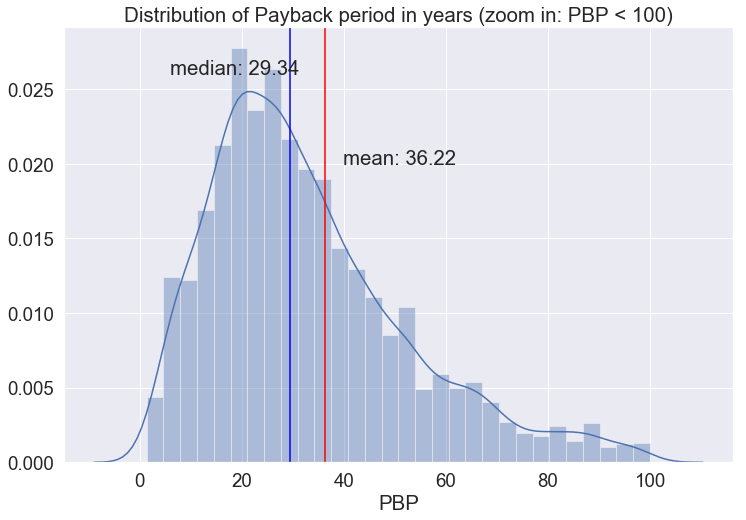

In [57]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(mapping[mapping['PBP'] <= 100]['PBP'], bins = 30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.title('Distribution of Payback period in years (zoom in: PBP < 100)')

mean = mapping['PBP'].mean()
median = mapping['PBP'].median()
ax.axvline(mean, c='red')
ax.axvline(median, c='blue')
ax.text(median*0.2,0.026, "median: " + str(round(median, 2)))
ax.text(mean*1.1,0.02, "mean: " + str(round(mean, 2)))

In [58]:
mapping_c = mapping[mapping['PBP'] < 10]
mapping_c

,zipcode,latitude,longitude,host_response_rate,host_response_time,host_is_superhost,borough,property_type,room_type,accommodates,bathrooms,beds,bed_type,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,neighbourhood_cleansed,f_price,index,median_value,PBP
41,11205,40.68975,-73.96703,0.89,within a day,False,Brooklyn,House,Private room,4,1.0,2.0,Real Bed,99.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict_14_with_grace_period,Clinton Hill,744.25000,Brooklyn,1.526200e+06,7.490977
96,11216,40.67147,-73.94979,1.00,within a day,False,Brooklyn,Apartment,Entire home/apt,5,2.0,2.0,Real Bed,100.0,10.0,10.0,10.0,10.0,9.0,8.0,False,strict_14_with_grace_period,Crown Heights,595.31250,Brooklyn,1.526200e+06,9.365098
116,11238,40.68418,-73.96926,1.00,within an hour,False,Brooklyn,Apartment,Entire home/apt,4,1.0,2.0,Real Bed,94.0,10.0,10.0,9.0,9.0,9.0,9.0,False,strict_14_with_grace_period,Fort Greene,603.43750,Brooklyn,1.526200e+06,9.239001
146,11238,40.68015,-73.96299,1.00,within an hour,False,Brooklyn,Townhouse,Entire home/apt,6,2.0,3.0,Real Bed,90.0,9.0,9.0,10.0,10.0,10.0,8.0,True,moderate,Crown Heights,568.43750,Brooklyn,1.526200e+06,9.807868
164,11211,40.71756,-73.94839,1.00,within an hour,True,Brooklyn,Condominium,Entire home/apt,6,3.0,3.0,Real Bed,96.0,10.0,10.0,10.0,10.0,10.0,9.0,False,moderate,Williamsburg,823.43750,Brooklyn,1.526200e+06,6.770593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5467,10301,40.64762,-74.08682,1.00,within a few hours,False,Staten Island,House,Entire home/apt,4,1.0,2.0,Real Bed,93.0,10.0,10.0,10.0,10.0,10.0,9.0,True,strict_14_with_grace_period,St. George,214.53125,Staten Island,5.173000e+05,8.808415
5471,10303,40.63531,-74.15789,1.00,within an hour,False,Staten Island,House,Entire home/apt,5,1.0,3.0,Real Bed,90.0,9.0,10.0,10.0,10.0,9.0,10.0,True,strict_14_with_grace_period,Mariners Harbor,241.71875,Staten Island,5.173000e+05,7.817682
5474,10305,40.60525,-74.06745,1.00,within a day,False,Staten Island,Apartment,Entire home/apt,6,2.0,2.0,Real Bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,flexible,Shore Acres,550.00000,Staten Island,5.173000e+05,3.435782
5475,10314,40.61035,-74.11711,1.00,within an hour,False,Staten Island,House,Entire home/apt,7,1.0,2.0,Real Bed,91.0,9.0,9.0,10.0,10.0,9.0,9.0,False,strict_14_with_grace_period,Emerson Hill,238.15625,Staten Island,5.173000e+05,7.934624


In [59]:
# [40.693943, -73.985880] are the coordinates of New York City (NYC).
map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=10)

map.choropleth(geo_data="nyc-zip-code-tabulation-areas-polygons.geojson",
             data=mapping, # my dataset
             columns=['zipcode', 'PBP'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='RdBu_r', fill_opacity=0.7, line_opacity=0.2,
             legend_name='daily price')

# add clustered marker
marker_cluster = MarkerCluster().add_to(map)

mapping_c = mapping[mapping['PBP'] <= 10]
mapping_c.reset_index(drop = True, inplace = True)

for i in range(mapping_c.shape[0]):
    location = [mapping_c['latitude'][i], mapping_c['longitude'][i]]
    tooltip = "Zipcode:{}<br> Neighbourhood: {} <br>Borough: {}<br> Click for more".\
      format(
        mapping_c["zipcode"][i], 
        mapping_c["neighbourhood_cleansed"][i], 
        mapping_c['borough'][i])
    
    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Daily Price: </i> <br> <b>${}</b> <br> 
                  <i>Payback Period: </i> <br> <b>${}</b> <br> 
                  <i># Accommodates: </i><b><br>{}</b><br>
                  <i># Room Type: </i><b><br>{}</b><br>
                  <i># Bathrooms: </i><b><br>{}</b><br>
                  """.format(
                    round(mapping_c['f_price'][i],2), 
                    round(mapping_c['PBP'][i],2), 
                    round(mapping_c['accommodates'][i],2), 
                    mapping_c['room_type'][i],
                    round(mapping_c['bathrooms'][i],2)),
                  tooltip=tooltip).add_to(marker_cluster)
map

#### How to read the map

The map has three layers - the base layer, the choropleth, and the markers. 

The choropleth is colored based on the payback period by each zipcode of two-bedroom property. The deeper the blue, the shorter the payback period, the more worthy the investment. The deeper the red is the reverse. Besides, the black indicates that the data does not cover these areas.

An individual marker is a property in the listing. To embellish the map, the markers are clustered when looked on high level, you can zoom in to have individual markers. Hovering over each marker will give you the location information of the property including the zipcode. By clicking it, you can see the approximate daily rental price and payback period on it.

The dataset contains 427 properties whose payback period is smaller than or equal to 10 years. See conclusions and recommended zipcode list in the next chapter.


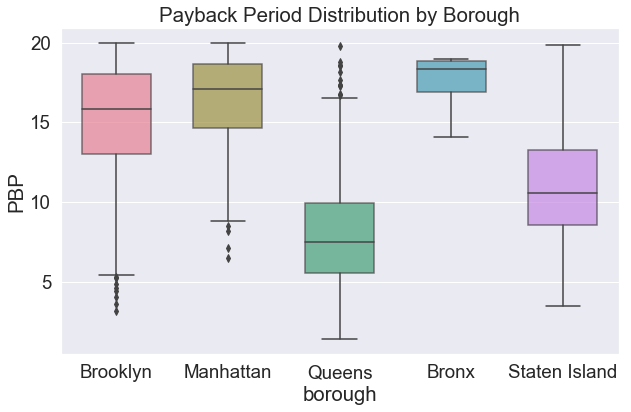

In [60]:
plt.figure(figsize=(10,6))
sns.boxplot(x='borough', y='PBP', data=mapping[mapping['PBP'] <= 20], palette = 'husl', boxprops=dict(alpha=.7), width = 0.618)
plt.title('Payback Period Distribution by Borough')
plt.show()

Consistent with the map, the boxplot above also shows that investment in Queens generally yields the lowest payback period, and the Staten Island the second. However, we are not sure how many properties on Staten Island are available for us to purchase, so the Company might also want to invest in Brooklyn

# 5. Conclusion and Recommendation


Based on the map, we recommend that the Company start from Queens, then Staten Island and Brooklyn if the cash is ready.

While the actual zipcodes to invest depends on the budget. A function has been wrapped up as below and the Company can employ it anytime you revise the budget and the widget will recommend the zipcodes accordingly.

According to our preset scenarios that the Company would have 1 million, 10 milliion, and 1 billion dollars for the project, the zipcode_finder list the solutions below:

Investing zipcodes with $1,000,000 at hand:  ['11101', '11375', '11102']

Investing zipcodes with $10,000,000 at hand:  ['11102', '11693', '11106', '11435', '11361', '11375', '11385', '11414', '11237', '11103', '11412', '11692', '11434', '11101']

Investing zipcodes with $1000,000,000 at hand:  ['11230', '10023', '11691', '11236', '11416', '11432', '10028', '11209', '10305', '11423', '11217', '10013', '11372', '11417', '11422', '11368', '11102', '11203', '11106', '11433', '11234', '10306', '10014', '11101', '10011', '10304', '10012', '10026', '11216', '11104', '11103', '11212', '11354', '11249', '11222', '10017', '11435', '10467', '11232', '11418', '10036', '10301', '10002', '11385', '11225', '10024', '11419', '11692', '11434', '10128', '11361', '11356', '10303', '11235', '10309', '10016', '11413', '11369', '11237', '11201', '11105', '11373', '10003', '11215', '11693', '11365', '11208', '11412', '11426', '10308', '11210', '11355', '11003', '10007', '10038', '11109', '11559', '11233', '11379', '11375', '11694', '11205', '11374', '11206', '11429', '11358', '11226', '10025', '11436', '11211', '11377', '11414', '11411', '11367', '10310', '11370', '11213', '10010', '10001', '10027', '11378', '11220', '10075', '11238', '11221', '11231', '10314']

All the available data products were listed in the appendix.

In [61]:
def zipcode_finder(data, budget):
    '''
    Return a list of most profitable zipcode the investor is seeking
    
    Input:
    data: a dataframe containing zipcode, payback period, and property value
    budget: the budget
    
    Return a list of zipcode to invest in
    '''
    
    data = data.sort_values(by = 'PBP')
    
    value = 0
    i = 0
    df = pd.DataFrame(columns = data.columns)
    
    while (value < budget) & (i <= data.shape[0]):
        df = df.append(data.iloc[i])
        value += data['median_value'].iloc[i]
        i += 1
        
    return list(set(df['zipcode']))
    
    

In [62]:
for b in [1000000, 10000000, 1000000000]:
    print('Investing zipcodes with ' + str(b) + ' dollar at hand: ', zipcode_finder(mapping, b))

Investing zipcodes with 1000000 dollar at hand:  ['11102', '11101', '11375']
Investing zipcodes with 10000000 dollar at hand:  ['11102', '11106', '11385', '11237', '11103', '11101', '11414', '11375', '11434', '11435', '11361', '11692', '11412', '11693']
Investing zipcodes with 1000000000 dollar at hand:  ['11216', '10010', '10314', '11102', '11208', '11234', '11205', '11422', '11235', '10025', '11210', '10013', '11106', '11101', '11355', '11232', '11692', '10304', '10036', '10026', '11419', '11201', '11691', '11249', '10128', '11203', '11413', '10011', '11238', '10305', '11370', '11559', '11215', '11105', '11693', '11233', '11385', '10024', '10306', '10075', '10023', '11418', '10007', '11237', '11694', '11103', '10027', '11372', '11361', '11423', '10014', '10038', '11429', '11432', '11231', '11417', '11369', '11213', '11375', '11003', '10467', '11354', '11436', '11412', '11365', '10017', '11356', '10012', '11411', '10002', '11206', '11373', '11414', '11377', '11374', '11225', '11220', 

# 6. What's Next




# Appendix

## Data products

Move the cursor to the function and push `shift`+`tab` to see the document of the function

In [ ]:
#### NOT RUN ####

# data tidying
update2date(i)

num_weeks(start, end)

# missing value check
mv_plot(data, title, threshold = 1000, xlim = 50000, top = 20, label_size = 15)

mv_heatmap(data, tick_itvl, threshold = 1000)

width_vertical(ax, new_value)

width_horizontal(ax, new_value)

# column check
countplot_h(column_x, data, x_upper_lim, top = 10, size = (9, 6), palette = 'husl', 
                title = 'Horizontal Countplot', ylabel = 'levels', bw = 0.618)
                
smt_loc(x)

# tidy airbnb
tidy_airbnb(airbnb)

# tidy zillow
tidy_zillow(data)

# merge new data of airbnb
merge_airbnb(old, new)

# merge new data of zillow
merge_zillow(info_old, ts_old, new)

# predict 
pred_med_value(data, lag)


# approximate the daily revenue
def y_calculator(x, y, z, c, m, n, e)

# give out recommendation
def zipcode_finder(data, budget)

## Holt's Method

Holt's method is equivalent to ARIMA(0,2,2). He extended Simple Exponential Smoothing to Linear Exponential Smoothing by allowing forecasting with trends

\begin{align*}
\text{Level: }   \; \quad \ell_t &=  \alpha y_t + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\
\text{Growth: }   \; \quad b_t &= \beta^* (\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1} \\
\text{Forecast: }\;  \hat{y}_{t+h|t} &= \ell_t + b_t h \\
\end{align*}

Here

$\alpha$ is a constant between 0 and 1. Depending on $\alpha$, the new forecast may change significantly from the old one.

$\ell_t$ is the estimate of the level at time  t  and

$b_t$  is an estimate of the slope (or growth) at time t.

# References

[1] Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles
    and practice. OTexts, 2014.
    
[2] [Time Series in Python — Exponential Smoothing and ARIMA processes](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788)

[3] [Time Series in Python — Part 2: Dealing with seasonal data](https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051)

[4] [Plotly: Time Series Plot with Custom Date Range](https://plot.ly/python/time-series/)

[5] [Interactive Map visualization with Folium in Python](https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b)

[6] [NYC property sales EDA - Map analysis](https://www.kaggle.com/saidakbarp/nyc-property-sales-eda-map-analysis/data#Map-analysis)

